In [22]:
# Importar librerías

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # Import patches module
import seaborn as sns
import re

In [23]:
# Web Scraping from Solotodo


base_url = "https://www.solotodo.cl/tarjetas_de_video?gpu_lines=1296931&gpu_lines=1686470&gpu_lines=2032605&gpu_lines=1240913&gpu_lines=1651050&gpu_lines=2014763&gpu_lines=1899054&gpu_lines=2017694&page_size=50"
all_productos = []
page_num = 1
scraping_active = True

# Add a user-agent header to mimic a browser
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
}

while scraping_active:
    url = f"{base_url}&page={page_num}"
    print(f"Scraping page {page_num}: {url}")

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status() # Raise an exception for bad status codes

        soup = BeautifulSoup(response.content, "html.parser")

        productos = []

        # Find all the product cards using the class identified in the HTML snippet
        cards = soup.select("div.MuiPaper-root.MuiPaper-elevation.MuiPaper-rounded.MuiPaper-elevation0.MuiCard-root")

        print(f"Found {len(cards)} potential product cards on page {page_num}.")

        if len(cards) == 0:
            print("No more products found. Stopping scraping.")
            scraping_active = False
        else:
            for card in cards:
                link = None # Initialize link to None
                try:
                    # Selector for the product link
                    link_tag = card.select_one("a")
                    if link_tag and 'href' in link_tag.attrs:
                        # Construct the full URL
                        link = "https://www.solotodo.cl" + link_tag['href']
                except Exception as e:
                    print(f"Error extracting link on page {page_num}: {e}")

                try:
                    # Selector for product name based on HTML snippet
                    nombre_tag = card.select_one("div.MuiTypography-root.MuiTypography-h5")
                    nombre = nombre_tag.text.strip() if nombre_tag else None
                except Exception as e:
                    nombre = None
                    print(f"Error extracting name on page {page_num}: {e}")


                try:
                    # Selector for price based on HTML snippet
                    precio_tag = card.select_one("div.MuiTypography-root.MuiTypography-h2")
                    precio = precio_tag.text.strip() if precio_tag else None
                except Exception as e:
                    precio = None
                    print(f"Error extracting price on page {page_num}: {e}")

                gpu = None
                memoria = None
                other_specs = {}
                try:
                    # Selector for specs section based on HTML snippet
                    specs_dl = card.select_one("div.ProductPage_product_specs__pYVnc dl")
                    if specs_dl:
                        for dt, dd in zip(specs_dl.select("dt"), specs_dl.select("dd")):
                            spec_name = dt.text.strip()
                            spec_value = dd.text.strip()
                            if spec_name == "GPU":
                                gpu = spec_value
                            elif spec_name == "Memoria":
                                memoria = spec_value
                            else:
                                other_specs[spec_name] = spec_value
                except Exception as e:
                    print(f"Error extracting specs on page {page_num}: {e}")


                productos.append({
                    "producto": nombre,
                    "precio": precio,
                    "gpu": gpu,
                    "memoria": memoria,
                    "other_specs": other_specs, # Include other specs if needed
                    "link": link # Add the extracted link
                })
            all_productos.extend(productos) # Append products from the current page
            page_num += 1 # Increment page number for the next iteration

            if scraping_active: # Only wait if scraping is still active
                print("Waiting 5 seconds before next page...")
                time.sleep(5)


    except requests.exceptions.RequestException as e:
        print(f"Error fetching the URL {url}: {e}")
        scraping_active = False # Stop scraping on request errors
    except Exception as e:
        print(f"An error occurred during scraping page {url}: {e}")
        scraping_active = False # Stop scraping on other errors


print(f"\nCollected a total of {len(all_productos)} products from all pages.")
print(all_productos) # Debugging print the collected data

df = pd.DataFrame(all_productos)
# Create a copy of df called solotodo_df
solotodo_df = df.copy()

display(df.head())
display(solotodo_df.head()) # Display the head of the new dataframe

Scraping page 1: https://www.solotodo.cl/tarjetas_de_video?gpu_lines=1296931&gpu_lines=1686470&gpu_lines=2032605&gpu_lines=1240913&gpu_lines=1651050&gpu_lines=2014763&gpu_lines=1899054&gpu_lines=2017694&page_size=50&page=1
Found 50 potential product cards on page 1.
Waiting 5 seconds before next page...
Scraping page 2: https://www.solotodo.cl/tarjetas_de_video?gpu_lines=1296931&gpu_lines=1686470&gpu_lines=2032605&gpu_lines=1240913&gpu_lines=1651050&gpu_lines=2014763&gpu_lines=1899054&gpu_lines=2017694&page_size=50&page=2
Found 50 potential product cards on page 2.
Waiting 5 seconds before next page...
Scraping page 3: https://www.solotodo.cl/tarjetas_de_video?gpu_lines=1296931&gpu_lines=1686470&gpu_lines=2032605&gpu_lines=1240913&gpu_lines=1651050&gpu_lines=2014763&gpu_lines=1899054&gpu_lines=2017694&page_size=50&page=3
Found 50 potential product cards on page 3.
Waiting 5 seconds before next page...
Scraping page 4: https://www.solotodo.cl/tarjetas_de_video?gpu_lines=1296931&gpu_line

,producto,precio,gpu,memoria,other_specs,link
0,MSI GeForce RTX 5060 8G VENTUS 2X OC [G5060-8V2C],$367.500,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),{'Frec. core (base / boost / OC)': '2280 / 249...,https://www.solotodo.cl/products/276439-msi-ge...
1,MSI GeForce RTX 3060 VENTUS 2X 12G OC,$302.990,NVIDIA GeForce RTX 3060,12 GB GDDR6 (192 bit),{'Frec. core (base / boost / OC)': '1320 / 177...,https://www.solotodo.cl/products/105998-msi-ge...
2,ASUS Prime Radeon RX 9070 XT OC Edition 16GB [...,$874.995,AMD Radeon RX 9070 XT,16 GB GDDR6 (256 bit),{'Frec. core (base / boost / OC)': '2400 / 297...,https://www.solotodo.cl/products/276343-asus-p...
3,ASUS DUAL-RX7600-O8G-EVO,$297.850,AMD Radeon RX 7600,8 GB GDDR6 (128 bit),{'Frec. core (base / boost / OC)': '1720 / 265...,https://www.solotodo.cl/products/270835-asus-d...
4,ASRock Radeon RX 9060 XT Challenger 16GB OC [R...,$479.900,AMD Radeon RX 9060 XT,16 GB GDDR6 (128 bit),{'Frec. core (base / boost / OC)': '2530 / 313...,https://www.solotodo.cl/products/278239-asrock...


,producto,precio,gpu,memoria,other_specs,link
0,MSI GeForce RTX 5060 8G VENTUS 2X OC [G5060-8V2C],$367.500,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),{'Frec. core (base / boost / OC)': '2280 / 249...,https://www.solotodo.cl/products/276439-msi-ge...
1,MSI GeForce RTX 3060 VENTUS 2X 12G OC,$302.990,NVIDIA GeForce RTX 3060,12 GB GDDR6 (192 bit),{'Frec. core (base / boost / OC)': '1320 / 177...,https://www.solotodo.cl/products/105998-msi-ge...
2,ASUS Prime Radeon RX 9070 XT OC Edition 16GB [...,$874.995,AMD Radeon RX 9070 XT,16 GB GDDR6 (256 bit),{'Frec. core (base / boost / OC)': '2400 / 297...,https://www.solotodo.cl/products/276343-asus-p...
3,ASUS DUAL-RX7600-O8G-EVO,$297.850,AMD Radeon RX 7600,8 GB GDDR6 (128 bit),{'Frec. core (base / boost / OC)': '1720 / 265...,https://www.solotodo.cl/products/270835-asus-d...
4,ASRock Radeon RX 9060 XT Challenger 16GB OC [R...,$479.900,AMD Radeon RX 9060 XT,16 GB GDDR6 (128 bit),{'Frec. core (base / boost / OC)': '2530 / 313...,https://www.solotodo.cl/products/278239-asrock...


In [24]:
# Function to extract VRAM amount, generation, and bus

def extract_memory_details(memoria_str):
    vram = None
    gen_vram = None
    vram_bus = None
    if isinstance(memoria_str, str):
        parts = memoria_str.replace('(', '').replace(')', '').split() # Remove parentheses before splitting
        if len(parts) >= 2:
            vram = " ".join(parts[:2]) # Extract VRAM amount (e.g., "8 GB")
        if len(parts) > 2:
            gen_vram = parts[2] # Extract VRAM generation (e.g., "GDDR7")
        # Find the part containing "bit"
        for i, part in enumerate(parts):
            if "bit" in part:
                if i > 0 and parts[i-1].isdigit():
                    vram_bus = f"{parts[i-1]} {part}" # Extract number and "bit" (e.g., "128 bit")
                else:
                    vram_bus = part # Just extract "bit" if no number is found before it
                break
    return vram, gen_vram, vram_bus

# Apply the function to create the new columns
# Use solotodo_df as the base for solotodo_final_df
solotodo_final_df = solotodo_df.copy()
solotodo_final_df[['vram', 'gen_vram', 'VRAM bus']] = solotodo_final_df['memoria'].apply(lambda x: pd.Series(extract_memory_details(x)))

# Remove space from 'vram' column
solotodo_final_df['vram'] = solotodo_final_df['vram'].str.replace(' ', '')

# Remove curly braces from 'other_specs' column (assuming it's a string representation of a dictionary)
# Use .loc to avoid SettingWithCopyWarning
solotodo_final_df.loc[:, 'other_specs'] = solotodo_final_df['other_specs'].astype(str).str.replace('{', '', regex=False).str.replace('}', '', regex=False)


# Define the list of GPUs for the condition
specific_gpus = [
    'AMD Radeon RX 9060 XT',
    'NVIDIA GeForce RTX 3050',
    'NVIDIA GeForce RTX 4060 Ti',
    'NVIDIA GeForce RTX 5060 Ti'
]

# Function to apply the conditional logic
def select_gpu_column(row):
    if row['gpu'] in specific_gpus:
        # Use the newly created 'vram' column
        return row['gpu'] + ' ' + row['vram'] if pd.notnull(row['vram']) else row['gpu']
    else:
        return row['gpu']

# Apply the function to create the new column
solotodo_final_df['selected_gpu'] = solotodo_final_df.apply(select_gpu_column, axis=1)

# Create the 'company' column
def extract_company(gpu_name):
    if isinstance(gpu_name, str):
        if gpu_name.startswith("NVIDIA"):
            return "NVIDIA"
        elif gpu_name.startswith("AMD"):
            return "AMD"
        elif gpu_name.startswith("Intel"):
            return "Intel"
    return None # Return None for unexpected formats

solotodo_final_df['company'] = solotodo_final_df['gpu'].apply(extract_company)

# Drop the 'selected_gpu' column
solotodo_final_df.drop(columns=['selected_gpu'], inplace=True)

# Create the new 'gpu model' column by concatenating 'gpu' and 'vram'
solotodo_final_df['gpu model'] = solotodo_final_df.apply(lambda row: f"{row['gpu']} {row['vram']}" if pd.notnull(row['gpu']) and pd.notnull(row['vram']) else row['gpu'], axis=1)

# Display the updated DataFrame with the new columns
display(solotodo_final_df.head())
display(solotodo_final_df.tail())

,producto,precio,gpu,memoria,other_specs,link,vram,gen_vram,VRAM bus,company,gpu model
0,MSI GeForce RTX 5060 8G VENTUS 2X OC [G5060-8V2C],$367.500,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost / OC)': '2280 / 2497...,https://www.solotodo.cl/products/276439-msi-ge...,8GB,GDDR7,128 bit,NVIDIA,NVIDIA GeForce RTX 5060 8GB
1,MSI GeForce RTX 3060 VENTUS 2X 12G OC,$302.990,NVIDIA GeForce RTX 3060,12 GB GDDR6 (192 bit),'Frec. core (base / boost / OC)': '1320 / 1777...,https://www.solotodo.cl/products/105998-msi-ge...,12GB,GDDR6,192 bit,NVIDIA,NVIDIA GeForce RTX 3060 12GB
2,ASUS Prime Radeon RX 9070 XT OC Edition 16GB [...,$874.995,AMD Radeon RX 9070 XT,16 GB GDDR6 (256 bit),'Frec. core (base / boost / OC)': '2400 / 2970...,https://www.solotodo.cl/products/276343-asus-p...,16GB,GDDR6,256 bit,AMD,AMD Radeon RX 9070 XT 16GB
3,ASUS DUAL-RX7600-O8G-EVO,$297.850,AMD Radeon RX 7600,8 GB GDDR6 (128 bit),'Frec. core (base / boost / OC)': '1720 / 2655...,https://www.solotodo.cl/products/270835-asus-d...,8GB,GDDR6,128 bit,AMD,AMD Radeon RX 7600 8GB
4,ASRock Radeon RX 9060 XT Challenger 16GB OC [R...,$479.900,AMD Radeon RX 9060 XT,16 GB GDDR6 (128 bit),'Frec. core (base / boost / OC)': '2530 / 3130...,https://www.solotodo.cl/products/278239-asrock...,16GB,GDDR6,128 bit,AMD,AMD Radeon RX 9060 XT 16GB


,producto,precio,gpu,memoria,other_specs,link,vram,gen_vram,VRAM bus,company,gpu model
218,Gigabyte Radeon RX 6500 XT EAGLE 4G [GV-R65XTE...,$302.990,AMD Radeon RX 6500 XT,4 GB GDDR6 (64 bit),'Frec. core (base / boost)': '2610 / 2815 MHz'...,https://www.solotodo.cl/products/131740-gigaby...,4GB,GDDR6,64 bit,AMD,AMD Radeon RX 6500 XT 4GB
219,Gigabyte Radeon RX 6600 XT GAMING OC PRO 8G [G...,$699.990,AMD Radeon RX 6600 XT,8 GB GDDR6 (128 bit),'Frec. core (base / boost / OC)': '1968 / 2589...,https://www.solotodo.cl/products/121729-gigaby...,8GB,GDDR6,128 bit,AMD,AMD Radeon RX 6600 XT 8GB
220,Gigabyte GeForce RTX 5080 WINDFORCE OC SFF 16G...,$1.699.900,NVIDIA GeForce RTX 5080,16 GB GDDR7 (256 bit),'Frec. core (base / boost / OC)': '2300 / 2617...,https://www.solotodo.cl/products/265425-gigaby...,16GB,GDDR7,256 bit,NVIDIA,NVIDIA GeForce RTX 5080 16GB
221,Gigabyte GeForce RTX 5080 GAMING OC 16G [GV-N5...,$1.649.900,NVIDIA GeForce RTX 5080,16 GB GDDR7 (256 bit),'Frec. core (base / boost / OC)': '2300 / 2617...,https://www.solotodo.cl/products/273179-gigaby...,16GB,GDDR7,256 bit,NVIDIA,NVIDIA GeForce RTX 5080 16GB
222,MSI GeForce RTX 3050 VENTUS 2X XS 8G OC,$274.900,NVIDIA GeForce RTX 3050,8 GB GDDR6 (128 bit),'Frec. core (base / boost / OC)': '1552 / 1777...,https://www.solotodo.cl/products/222484-msi-ge...,8GB,GDDR6,128 bit,NVIDIA,NVIDIA GeForce RTX 3050 8GB


In [25]:
# Web scraping from Tom's Hardware

url = "https://www.tomshardware.com/reviews/gpu-hierarchy,4388.html"
response = requests.get(url)

soup = BeautifulSoup(response.content, 'html.parser')

# buscar las tablas
tables = soup.find_all('table')

rasterization_table = None
ray_tracing_table = None
ai_table = None

for table in tables:
    # Check for headers or significant text near the table to identify it
    previous_siblings = table.find_previous_siblings()
    for sibling in previous_siblings:
        if 'GPU Benchmarks Hierarchy — Rasterization Performance' in sibling.text:
            rasterization_table = table
            break
        elif 'GPU Benchmarks Hierarchy — Ray Tracing Performance' in sibling.text:
            ray_tracing_table = table
            break
        elif 'GPU Benchmarks Hierarchy — AI / Professional / Content Creation Performance' in sibling.text:
            ai_table = table
            break


tables = soup.find_all('table')

rasterization_table = None
ray_tracing_table = None
ai_table = None

# Search for elements containing the specific text
for element in soup.find_all(string=lambda text: text and 'GPU Benchmarks Hierarchy — Rasterization Performance' in text):
    # Find the closest ancestor that is a table or has a table descendant
    table = element.find_parent('table') or element.find_next('table')
    if table:
        rasterization_table = table
        break # Assuming there's only one such table

for element in soup.find_all(string=lambda text: text and 'GPU Benchmarks Hierarchy — Ray Tracing Performance' in text):
    table = element.find_parent('table') or element.find_next('table')
    if table:
        ray_tracing_table = table
        break

for element in soup.find_all(string=lambda text: text and 'GPU Benchmarks Hierarchy — AI / Professional / Content Creation Performance' in text):
    table = element.find_parent('table') or element.find_next('table')
    if table:
        ai_table = table
        break

print(f"Rasterization Table Found: {rasterization_table is not None}")
print(f"Ray Tracing Table Found: {ray_tracing_table is not None}")
print(f"AI Table Found: {ai_table is not None}")

table_data = {}

tables_to_process = {
    "rasterization_performance": rasterization_table,
    "ray_tracing_performance": ray_tracing_table,
    "ai_performance": ai_table
}

for name, table in tables_to_process.items():
    if table:
        headers = []
        # Extract headers from the thead section
        thead = table.find('thead')
        if thead:
            header_cells = thead.find_all('th')
            headers = [cell.text.strip() for cell in header_cells]

        rows = []
        # Extract rows from the tbody section
        tbody = table.find('tbody')
        if tbody:
            body_rows = tbody.find_all('tr')
            for row in body_rows:
                # Extract data from td cells
                data_cells = row.find_all('td')
                row_data = [cell.text.strip() for cell in data_cells]
                if row_data: # Only add if row is not empty
                    rows.append(row_data)

        table_data[name] = {
            "headers": headers,
            "rows": rows
        }
    else:
        print(f"Table '{name}' was not found.")

dfs = {}

# Keep 'Specifications (Links to Review)' by removing it from the columns_to_drop list
columns_to_drop = ['Lowest Price']


# Renaming dataframes based on user request
df_names_mapping = {
    "rasterization_performance": "raster_perf_df",
    "ray_tracing_performance": "rt_perf_df",
    "ai_performance": "ai_perf_df"
}

for name, data in table_data.items():
    if data:
        df_name = df_names_mapping.get(name, f"{name}_df") # Use the new name if in mapping
        dfs[df_name] = pd.DataFrame(data["rows"], columns=data["headers"])
        # Drop specified columns if they exist
        dfs[df_name].drop(columns=[col for col in columns_to_drop if col in dfs[df_name].columns], inplace=True)
        print(f"Created DataFrame '{df_name}' with {len(data['rows'])} rows and {len(dfs[df_name].columns)} columns after dropping.")

# Display the first few rows of each created DataFrame
for df_name, dataframe in dfs.items():
    print(f"\n{df_name}:")
    display(dataframe.head())

Rasterization Table Found: True
Ray Tracing Table Found: True
AI Table Found: True
Created DataFrame 'raster_perf_df' with 34 rows and 7 columns after dropping.
Created DataFrame 'rt_perf_df' with 34 rows and 7 columns after dropping.
Created DataFrame 'ai_perf_df' with 35 rows and 4 columns after dropping.

raster_perf_df:


,Graphics Card,MSRP,1080p Medium,1080p Ultra,1440p Ultra,4K Ultra,Specifications (Links to Review)
0,GeForce RTX 5090,"$1,999",100.0% (197.5),100.0% (157.6),100.0% (143.0),100.0% (105.8),"GB202, 21760 shaders, 2407MHz, 32GB GDDR7@28Gb..."
1,GeForce RTX 4090,"$1,599",99.0% (195.6),95.2% (150.1),88.6% (126.6),80.3% (85.0),"AD102, 16384 shaders, 2520MHz, 24GB GDDR6X@21G..."
2,GeForce RTX 5080,$999,90.4% (178.5),84.9% (133.9),78.1% (111.7),67.2% (71.1),"GB203, 10752 shaders, 2617MHz, 16GB GDDR7@30Gb..."
3,GeForce RTX 4080 Super,$999,89.7% (177.2),83.2% (131.1),74.0% (105.8),61.2% (64.8),"AD103, 10240 shaders, 2550MHz, 16GB GDDR6X@23G..."
4,GeForce RTX 4080,"$1,199",88.6% (175.0),82.0% (129.3),72.5% (103.7),59.4% (62.8),"AD103, 9728 shaders, 2505MHz, 16GB GDDR6X@22.4..."



rt_perf_df:


,Graphics Card,MSRP,1080p Medium,1080p Ultra,1440p Ultra,4K Ultra,Specifications (Links to Review)
0,GeForce RTX 5090,"$1,999",98.5% (200.3),100.0% (154.6),100.0% (137.7),100.0% (89.6),"GB202, 21760 shaders, 2407MHz, 32GB GDDR7@28Gb..."
1,GeForce RTX 4090,"$1,599",100.0% (203.3),97.7% (151.1),87.1% (119.9),79.3% (71.0),"AD102, 16384 shaders, 2520MHz, 24GB GDDR6X@21G..."
2,GeForce RTX 5080,$999,84.9% (172.6),84.9% (131.2),73.0% (100.5),63.7% (57.0),"GB203, 10752 shaders, 2617MHz, 16GB GDDR7@30Gb..."
3,GeForce RTX 5070 Ti,$749,84.4% (171.5),85.0% (131.4),71.7% (98.7),62.4% (55.9),"GB203, 8960 shaders, 2452MHz, 16GB GDDR7@28Gbp..."
4,GeForce RTX 4080 Super,$999,91.3% (185.6),83.5% (129.0),68.8% (94.8),58.2% (52.1),"AD103, 10240 shaders, 2550MHz, 16GB GDDR6X@23G..."



ai_perf_df:


,Graphics Card,MSRP,AI/Pro/Viz Perf,Specifications (Links to Review)
0,GeForce RTX 5090,"$1,999",100.0% (862.8),"GB202, 21760 shaders, 2407MHz, 32GB GDDR7@28Gb..."
1,GeForce RTX 4090,"$1,599",78.9% (681.0),"AD102, 16384 shaders, 2520MHz, 24GB GDDR6X@21G..."
2,GeForce RTX 5080,$999,69.8% (601.9),"GB203, 10752 shaders, 2617MHz, 16GB GDDR7@30Gb..."
3,GeForce RTX 4080 Super,$999,65.6% (565.7),"AD103, 10240 shaders, 2550MHz, 16GB GDDR6X@23G..."
4,GeForce RTX 4080,"$1,199",63.5% (547.8),"AD103, 9728 shaders, 2505MHz, 16GB GDDR6X@22.4..."


In [26]:
# List of performance DataFrames
performance_dfs = [dfs['raster_perf_df'], dfs['rt_perf_df'], dfs['ai_perf_df']]
df_names = ['raster_perf_df', 'rt_perf_df', 'ai_perf_df']

# Melt each DataFrame to long format
melted_dfs = {}
for df, name in zip(performance_dfs, df_names):
    # Determine which columns to melt based on the DataFrame
    if name == 'ai_perf_df':
        performance_cols = ['AI/Pro/Viz Perf']
        # Include 'Specifications (Links to Review)' in id_vars for AI dataframe
        id_vars_list = ['Graphics Card', 'MSRP', 'Specifications (Links to Review)']
    else:
        performance_cols = ['1080p Medium', '1080p Ultra', '1440p Ultra', '4K Ultra']
        # Include 'Specifications (Links to Review)' in id_vars for other dataframes
        id_vars_list = ['Graphics Card', 'MSRP', 'Specifications (Links to Review)']


    # Check if performance_cols exist in the DataFrame before melting
    cols_to_melt = [col for col in performance_cols if col in df.columns]
    # Also check if id_vars_list columns exist
    id_vars_list = [col for col in id_vars_list if col in df.columns]


    if cols_to_melt:
        melted_df = df.melt(id_vars=id_vars_list,
                            value_vars=cols_to_melt,
                            var_name='Performance Type',
                            value_name='Performance Value')

        # Split 'Performance Value' into 'Percent perf' and 'FPS perf'
        # Handle cases where the value might not have parentheses
        split_values = melted_df['Performance Value'].str.extract(r'(\d+\.?\d*)%\s*\((\d+\.?\d*)\)')
        melted_df['Percent perf'] = pd.to_numeric(split_values[0], errors='coerce')
        melted_df['FPS perf'] = pd.to_numeric(split_values[1], errors='coerce')

        # For AI/Pro/Viz Perf, the format is slightly different, handle it separately
        if name == 'ai_perf_df':
             split_values_ai = melted_df['Performance Value'].str.extract(r'(\d+\.?\d*)%\s*\(([\d\.]+)\)')
             melted_df['Percent perf'] = pd.to_numeric(split_values_ai[0], errors='coerce')
             melted_df['FPS perf'] = pd.to_numeric(split_values_ai[1], errors='coerce')


        melted_dfs[name] = melted_df
        print(f"\nMelted DataFrame: {name}")
        display(melted_dfs[name].head())
    else:
        print(f"\nNo performance columns found to melt in DataFrame: {name}")


# Update the original DataFrames with the melted versions
if 'raster_perf_df' in melted_dfs:
    raster_perf_df_long = melted_dfs['raster_perf_df']
    raster_perf_df_long['Test type'] = 'Raw performance'
if 'rt_perf_df' in melted_dfs:
    rt_perf_df_long = melted_dfs['rt_perf_df']
    rt_perf_df_long['Test type'] = 'Raytracing'
if 'ai_perf_df' in melted_dfs:
    ai_perf_df_long = melted_dfs['ai_perf_df']
    ai_perf_df_long['Test type'] = 'Productivity'

print("\nMelted Dataframes created: raster_perf_df_long, rt_perf_df_long, ai_perf_df_long with 'Test type', 'Percent perf', 'FPS perf', and 'Specifications (Links to Review)' columns.")


Melted DataFrame: raster_perf_df


,Graphics Card,MSRP,Specifications (Links to Review),Performance Type,Performance Value,Percent perf,FPS perf
0,GeForce RTX 5090,"$1,999","GB202, 21760 shaders, 2407MHz, 32GB GDDR7@28Gb...",1080p Medium,100.0% (197.5),100.0,197.5
1,GeForce RTX 4090,"$1,599","AD102, 16384 shaders, 2520MHz, 24GB GDDR6X@21G...",1080p Medium,99.0% (195.6),99.0,195.6
2,GeForce RTX 5080,$999,"GB203, 10752 shaders, 2617MHz, 16GB GDDR7@30Gb...",1080p Medium,90.4% (178.5),90.4,178.5
3,GeForce RTX 4080 Super,$999,"AD103, 10240 shaders, 2550MHz, 16GB GDDR6X@23G...",1080p Medium,89.7% (177.2),89.7,177.2
4,GeForce RTX 4080,"$1,199","AD103, 9728 shaders, 2505MHz, 16GB GDDR6X@22.4...",1080p Medium,88.6% (175.0),88.6,175.0



Melted DataFrame: rt_perf_df


,Graphics Card,MSRP,Specifications (Links to Review),Performance Type,Performance Value,Percent perf,FPS perf
0,GeForce RTX 5090,"$1,999","GB202, 21760 shaders, 2407MHz, 32GB GDDR7@28Gb...",1080p Medium,98.5% (200.3),98.5,200.3
1,GeForce RTX 4090,"$1,599","AD102, 16384 shaders, 2520MHz, 24GB GDDR6X@21G...",1080p Medium,100.0% (203.3),100.0,203.3
2,GeForce RTX 5080,$999,"GB203, 10752 shaders, 2617MHz, 16GB GDDR7@30Gb...",1080p Medium,84.9% (172.6),84.9,172.6
3,GeForce RTX 5070 Ti,$749,"GB203, 8960 shaders, 2452MHz, 16GB GDDR7@28Gbp...",1080p Medium,84.4% (171.5),84.4,171.5
4,GeForce RTX 4080 Super,$999,"AD103, 10240 shaders, 2550MHz, 16GB GDDR6X@23G...",1080p Medium,91.3% (185.6),91.3,185.6



Melted DataFrame: ai_perf_df


,Graphics Card,MSRP,Specifications (Links to Review),Performance Type,Performance Value,Percent perf,FPS perf
0,GeForce RTX 5090,"$1,999","GB202, 21760 shaders, 2407MHz, 32GB GDDR7@28Gb...",AI/Pro/Viz Perf,100.0% (862.8),100.0,862.8
1,GeForce RTX 4090,"$1,599","AD102, 16384 shaders, 2520MHz, 24GB GDDR6X@21G...",AI/Pro/Viz Perf,78.9% (681.0),78.9,681.0
2,GeForce RTX 5080,$999,"GB203, 10752 shaders, 2617MHz, 16GB GDDR7@30Gb...",AI/Pro/Viz Perf,69.8% (601.9),69.8,601.9
3,GeForce RTX 4080 Super,$999,"AD103, 10240 shaders, 2550MHz, 16GB GDDR6X@23G...",AI/Pro/Viz Perf,65.6% (565.7),65.6,565.7
4,GeForce RTX 4080,"$1,199","AD103, 9728 shaders, 2505MHz, 16GB GDDR6X@22.4...",AI/Pro/Viz Perf,63.5% (547.8),63.5,547.8



Melted Dataframes created: raster_perf_df_long, rt_perf_df_long, ai_perf_df_long with 'Test type', 'Percent perf', 'FPS perf', and 'Specifications (Links to Review)' columns.


In [27]:
# Concatenate the melted dataframes into a single dataframe
tomh_df = pd.concat([raster_perf_df_long, rt_perf_df_long, ai_perf_df_long], ignore_index=True)

print("Combined DataFrame 'tomh_df' created:")
display(tomh_df.head())
display(tomh_df.tail())

Combined DataFrame 'tomh_df' created:


,Graphics Card,MSRP,Specifications (Links to Review),Performance Type,Performance Value,Percent perf,FPS perf,Test type
0,GeForce RTX 5090,"$1,999","GB202, 21760 shaders, 2407MHz, 32GB GDDR7@28Gb...",1080p Medium,100.0% (197.5),100.0,197.5,Raw performance
1,GeForce RTX 4090,"$1,599","AD102, 16384 shaders, 2520MHz, 24GB GDDR6X@21G...",1080p Medium,99.0% (195.6),99.0,195.6,Raw performance
2,GeForce RTX 5080,$999,"GB203, 10752 shaders, 2617MHz, 16GB GDDR7@30Gb...",1080p Medium,90.4% (178.5),90.4,178.5,Raw performance
3,GeForce RTX 4080 Super,$999,"AD103, 10240 shaders, 2550MHz, 16GB GDDR6X@23G...",1080p Medium,89.7% (177.2),89.7,177.2,Raw performance
4,GeForce RTX 4080,"$1,199","AD103, 9728 shaders, 2505MHz, 16GB GDDR6X@22.4...",1080p Medium,88.6% (175.0),88.6,175.0,Raw performance


,Graphics Card,MSRP,Specifications (Links to Review),Performance Type,Performance Value,Percent perf,FPS perf,Test type
302,Intel Arc B570,$219,"BMG-G21, 2304 shaders, 2750MHz, 10GB GDDR6@19G...",AI/Pro/Viz Perf,22.1% (190.5),22.1,190.5,Productivity
303,Radeon RX 7600,$269,"Navi 33, 2048 shaders, 2655MHz, 8GB GDDR6@18Gb...",AI/Pro/Viz Perf,21.7% (187.4),21.7,187.4,Productivity
304,Intel Arc A580,$179,"ACM-G10, 3072 shaders, 2300MHz, 8GB GDDR6@16Gb...",AI/Pro/Viz Perf,20.7% (178.8),20.7,178.8,Productivity
305,GeForce RTX 3050 8GB,$249,"GA106, 2560 shaders, 1777MHz, 8GB GDDR6@14Gbps...",AI/Pro/Viz Perf,16.6% (143.5),16.6,143.5,Productivity
306,Radeon RX 6600,$329,"Navi 23, 1792 shaders, 2491MHz, 8GB GDDR6@14Gb...",AI/Pro/Viz Perf,15.2% (130.8),15.2,130.8,Productivity


In [28]:
# Create 'Graphics Card step1' column based on conditions
def format_graphics_card_step1(card_name):
    if isinstance(card_name, str):
        if card_name.startswith("GeForce"):
            return "NVIDIA " + card_name
        elif card_name.startswith("Radeon"):
            return "AMD " + card_name
        elif card_name.startswith("Intel"):
            return card_name # Keep as is for Intel
    return card_name # Return original if not a string or doesn't match prefixes

# Use 'Graphics Card' as the base column, as 'Graphics Card updated' does not exist
tomh_df['Graphics Card step1'] = tomh_df['Graphics Card'].apply(format_graphics_card_step1)

import re

def create_final_graphics_card(row):
    card_step1 = row['Graphics Card step1']
    specs = row['Specifications (Links to Review)']

    # Check if VRAM is already in Graphics Card step1 (look for patterns like ' 8GB', ' 12GB', etc.)
    # Need to be careful not to match numbers that are not VRAM.
    # A simple check for a number followed by "GB" or "G" at the end might work for common cases.
    if re.search(r'\d+GB$', card_step1) or re.search(r'\d+ G$', card_step1):
        return card_step1 # Keep as is if VRAM is likely already present

    # If VRAM is not in step1, try to extract it from Specifications (Links to Review)
    vram_match = re.search(r'(\d+GB|\d+ G)', specs) # Look for patterns like '32GB', '24GB', '16GB', '12GB', '8GB', '6GB', '4GB', '2GB'
    if vram_match:
        extracted_vram = vram_match.group(1).strip()
        # Clean up extracted VRAM format if necessary (e.g., change "12 G" to "12GB")
        extracted_vram = extracted_vram.replace(' G', 'GB')

        return f"{card_step1} {extracted_vram}" # Concatenate with space

    return card_step1 # Return original if no VRAM found in specs or already present and not matched by first check

# Apply the function to create the new column
tomh_df['Graphics Card final'] = tomh_df.apply(create_final_graphics_card, axis=1)

print("Created 'Graphics Card final' column in tomh_df:")
display(tomh_df.head())
display(tomh_df.tail())

Created 'Graphics Card final' column in tomh_df:


,Graphics Card,MSRP,Specifications (Links to Review),Performance Type,Performance Value,Percent perf,FPS perf,Test type,Graphics Card step1,Graphics Card final
0,GeForce RTX 5090,"$1,999","GB202, 21760 shaders, 2407MHz, 32GB GDDR7@28Gb...",1080p Medium,100.0% (197.5),100.0,197.5,Raw performance,NVIDIA GeForce RTX 5090,NVIDIA GeForce RTX 5090 32GB
1,GeForce RTX 4090,"$1,599","AD102, 16384 shaders, 2520MHz, 24GB GDDR6X@21G...",1080p Medium,99.0% (195.6),99.0,195.6,Raw performance,NVIDIA GeForce RTX 4090,NVIDIA GeForce RTX 4090 24GB
2,GeForce RTX 5080,$999,"GB203, 10752 shaders, 2617MHz, 16GB GDDR7@30Gb...",1080p Medium,90.4% (178.5),90.4,178.5,Raw performance,NVIDIA GeForce RTX 5080,NVIDIA GeForce RTX 5080 16GB
3,GeForce RTX 4080 Super,$999,"AD103, 10240 shaders, 2550MHz, 16GB GDDR6X@23G...",1080p Medium,89.7% (177.2),89.7,177.2,Raw performance,NVIDIA GeForce RTX 4080 Super,NVIDIA GeForce RTX 4080 Super 16GB
4,GeForce RTX 4080,"$1,199","AD103, 9728 shaders, 2505MHz, 16GB GDDR6X@22.4...",1080p Medium,88.6% (175.0),88.6,175.0,Raw performance,NVIDIA GeForce RTX 4080,NVIDIA GeForce RTX 4080 16GB


,Graphics Card,MSRP,Specifications (Links to Review),Performance Type,Performance Value,Percent perf,FPS perf,Test type,Graphics Card step1,Graphics Card final
302,Intel Arc B570,$219,"BMG-G21, 2304 shaders, 2750MHz, 10GB GDDR6@19G...",AI/Pro/Viz Perf,22.1% (190.5),22.1,190.5,Productivity,Intel Arc B570,Intel Arc B570 10GB
303,Radeon RX 7600,$269,"Navi 33, 2048 shaders, 2655MHz, 8GB GDDR6@18Gb...",AI/Pro/Viz Perf,21.7% (187.4),21.7,187.4,Productivity,AMD Radeon RX 7600,AMD Radeon RX 7600 8GB
304,Intel Arc A580,$179,"ACM-G10, 3072 shaders, 2300MHz, 8GB GDDR6@16Gb...",AI/Pro/Viz Perf,20.7% (178.8),20.7,178.8,Productivity,Intel Arc A580,Intel Arc A580 8GB
305,GeForce RTX 3050 8GB,$249,"GA106, 2560 shaders, 1777MHz, 8GB GDDR6@14Gbps...",AI/Pro/Viz Perf,16.6% (143.5),16.6,143.5,Productivity,NVIDIA GeForce RTX 3050 8GB,NVIDIA GeForce RTX 3050 8GB
306,Radeon RX 6600,$329,"Navi 23, 1792 shaders, 2491MHz, 8GB GDDR6@14Gb...",AI/Pro/Viz Perf,15.2% (130.8),15.2,130.8,Productivity,AMD Radeon RX 6600,AMD Radeon RX 6600 8GB


In [29]:
# Crear columnas necesarias.

def create_final_graphics_card(row):
    card_step1 = row['Graphics Card step1']
    specs = row['Specifications (Links to Review)']

    # Check if VRAM is already in Graphics Card step1 (look for patterns like ' 8GB', ' 12GB', etc.)
    # Need to be careful not to match numbers that are not VRAM.
    # A simple check for a number followed by "GB" or "G" at the end might work for common cases.
    if re.search(r'\d+GB$', card_step1) or re.search(r'\d+ G$', card_step1):
        return card_step1 # Keep as is if VRAM is likely already present

    # If VRAM is not in step1, try to extract it from Specifications (Links to Review)
    vram_match = re.search(r'(\d+GB|\d+ G)', specs) # Look for patterns like '32GB', '24GB', '16GB', '12GB', '8GB', '6GB', '4GB', '2GB'
    if vram_match:
        extracted_vram = vram_match.group(1).strip()
        # Clean up extracted VRAM format if necessary (e.g., change "12 G" to "12GB")
        extracted_vram = extracted_vram.replace(' G', 'GB')

        return f"{card_step1} {extracted_vram}" # Concatenate with space

    return card_step1 # Return original if no VRAM found in specs or already present and not matched by first check

# Apply the function to create the new column
tomh_df['Graphics Card final'] = tomh_df.apply(create_final_graphics_card, axis=1)

print("Created 'Graphics Card final' column in tomh_df:")

# Create the new column 'Test Performance Type' by concatenating 'Test type' and 'Performance Type'
tomh_df['Test Performance Type'] = tomh_df['Test type'] + ' ' + tomh_df['Performance Type']

print("Created 'Test Performance Type' column in tomh_df:")
display(tomh_df.head())
display(tomh_df.tail())

Created 'Graphics Card final' column in tomh_df:
Created 'Test Performance Type' column in tomh_df:


,Graphics Card,MSRP,Specifications (Links to Review),Performance Type,Performance Value,Percent perf,FPS perf,Test type,Graphics Card step1,Graphics Card final,Test Performance Type
0,GeForce RTX 5090,"$1,999","GB202, 21760 shaders, 2407MHz, 32GB GDDR7@28Gb...",1080p Medium,100.0% (197.5),100.0,197.5,Raw performance,NVIDIA GeForce RTX 5090,NVIDIA GeForce RTX 5090 32GB,Raw performance 1080p Medium
1,GeForce RTX 4090,"$1,599","AD102, 16384 shaders, 2520MHz, 24GB GDDR6X@21G...",1080p Medium,99.0% (195.6),99.0,195.6,Raw performance,NVIDIA GeForce RTX 4090,NVIDIA GeForce RTX 4090 24GB,Raw performance 1080p Medium
2,GeForce RTX 5080,$999,"GB203, 10752 shaders, 2617MHz, 16GB GDDR7@30Gb...",1080p Medium,90.4% (178.5),90.4,178.5,Raw performance,NVIDIA GeForce RTX 5080,NVIDIA GeForce RTX 5080 16GB,Raw performance 1080p Medium
3,GeForce RTX 4080 Super,$999,"AD103, 10240 shaders, 2550MHz, 16GB GDDR6X@23G...",1080p Medium,89.7% (177.2),89.7,177.2,Raw performance,NVIDIA GeForce RTX 4080 Super,NVIDIA GeForce RTX 4080 Super 16GB,Raw performance 1080p Medium
4,GeForce RTX 4080,"$1,199","AD103, 9728 shaders, 2505MHz, 16GB GDDR6X@22.4...",1080p Medium,88.6% (175.0),88.6,175.0,Raw performance,NVIDIA GeForce RTX 4080,NVIDIA GeForce RTX 4080 16GB,Raw performance 1080p Medium


,Graphics Card,MSRP,Specifications (Links to Review),Performance Type,Performance Value,Percent perf,FPS perf,Test type,Graphics Card step1,Graphics Card final,Test Performance Type
302,Intel Arc B570,$219,"BMG-G21, 2304 shaders, 2750MHz, 10GB GDDR6@19G...",AI/Pro/Viz Perf,22.1% (190.5),22.1,190.5,Productivity,Intel Arc B570,Intel Arc B570 10GB,Productivity AI/Pro/Viz Perf
303,Radeon RX 7600,$269,"Navi 33, 2048 shaders, 2655MHz, 8GB GDDR6@18Gb...",AI/Pro/Viz Perf,21.7% (187.4),21.7,187.4,Productivity,AMD Radeon RX 7600,AMD Radeon RX 7600 8GB,Productivity AI/Pro/Viz Perf
304,Intel Arc A580,$179,"ACM-G10, 3072 shaders, 2300MHz, 8GB GDDR6@16Gb...",AI/Pro/Viz Perf,20.7% (178.8),20.7,178.8,Productivity,Intel Arc A580,Intel Arc A580 8GB,Productivity AI/Pro/Viz Perf
305,GeForce RTX 3050 8GB,$249,"GA106, 2560 shaders, 1777MHz, 8GB GDDR6@14Gbps...",AI/Pro/Viz Perf,16.6% (143.5),16.6,143.5,Productivity,NVIDIA GeForce RTX 3050 8GB,NVIDIA GeForce RTX 3050 8GB,Productivity AI/Pro/Viz Perf
306,Radeon RX 6600,$329,"Navi 23, 1792 shaders, 2491MHz, 8GB GDDR6@14Gb...",AI/Pro/Viz Perf,15.2% (130.8),15.2,130.8,Productivity,AMD Radeon RX 6600,AMD Radeon RX 6600 8GB,Productivity AI/Pro/Viz Perf


# Combinar ambos dataframes

In [30]:
# 1. PREPARE TOM'S HARDWARE DATA

tomh_performance = tomh_df[['Graphics Card final', 'Test Performance Type', 'Percent perf', 'FPS perf']]
display(tomh_performance.head())

# 2. GENERAR COMBINACIONES.

# Get unique 'gpu model' from solotodo_final_df
unique_gpu_models = solotodo_final_df['gpu model'].unique()

# Get unique 'Test Performance Type' from tomh_df
unique_test_performance_types = tomh_df['Test Performance Type'].unique()

# Create a DataFrame of all combinations
combinations_df = pd.DataFrame([(gpu, test_type) for gpu in unique_gpu_models for test_type in unique_test_performance_types],
                               columns=['gpu model', 'Test Performance Type'])

# Rename the 'gpu model' column to 'Graphics Card final'
combinations_df.rename(columns={'gpu model': 'Graphics Card final'}, inplace=True)

# Display the first few rows
print("\nCombinations DataFrame 'combinations_df' created:")
display(combinations_df.head())

# 3. COMBINAR CON SOLOTODO DATA

# Perform a left merge of combinations_df with solotodo_final_df
merged_solotodo_combinations = pd.merge(combinations_df, solotodo_final_df,
                                        left_on='Graphics Card final',
                                        right_on='gpu model',
                                        how='left')

# Display the head of the merged DataFrame
print("\nMerged DataFrame 'merged_solotodo_combinations' created:")
display(merged_solotodo_combinations.head())

# 4. COMBINAR CON TOM'S HARDWARE DATA

# Perform a left merge of merged_solotodo_combinations with tomh_performance
df_consolidado = pd.merge(merged_solotodo_combinations, tomh_performance,
                          on=['Graphics Card final', 'Test Performance Type'],
                          how='left')

# Display the head of the final merged DataFrame
print("\nFinal consolidated DataFrame 'df_consolidado' created:")
display(df_consolidado.head())


,Graphics Card final,Test Performance Type,Percent perf,FPS perf
0,NVIDIA GeForce RTX 5090 32GB,Raw performance 1080p Medium,100.0,197.5
1,NVIDIA GeForce RTX 4090 24GB,Raw performance 1080p Medium,99.0,195.6
2,NVIDIA GeForce RTX 5080 16GB,Raw performance 1080p Medium,90.4,178.5
3,NVIDIA GeForce RTX 4080 Super 16GB,Raw performance 1080p Medium,89.7,177.2
4,NVIDIA GeForce RTX 4080 16GB,Raw performance 1080p Medium,88.6,175.0



Combinations DataFrame 'combinations_df' created:


,Graphics Card final,Test Performance Type
0,NVIDIA GeForce RTX 5060 8GB,Raw performance 1080p Medium
1,NVIDIA GeForce RTX 5060 8GB,Raw performance 1080p Ultra
2,NVIDIA GeForce RTX 5060 8GB,Raw performance 1440p Ultra
3,NVIDIA GeForce RTX 5060 8GB,Raw performance 4K Ultra
4,NVIDIA GeForce RTX 5060 8GB,Raytracing 1080p Medium



Merged DataFrame 'merged_solotodo_combinations' created:


,Graphics Card final,Test Performance Type,producto,precio,gpu,memoria,other_specs,link,vram,gen_vram,VRAM bus,company,gpu model
0,NVIDIA GeForce RTX 5060 8GB,Raw performance 1080p Medium,MSI GeForce RTX 5060 8G VENTUS 2X OC [G5060-8V2C],$367.500,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost / OC)': '2280 / 2497...,https://www.solotodo.cl/products/276439-msi-ge...,8GB,GDDR7,128 bit,NVIDIA,NVIDIA GeForce RTX 5060 8GB
1,NVIDIA GeForce RTX 5060 8GB,Raw performance 1080p Medium,ASUS Dual GeForce RTX 5060 8GB GDDR7 OC Editio...,$374.890,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost / OC)': '2280 / 2497...,https://www.solotodo.cl/products/274360-asus-d...,8GB,GDDR7,128 bit,NVIDIA,NVIDIA GeForce RTX 5060 8GB
2,NVIDIA GeForce RTX 5060 8GB,Raw performance 1080p Medium,Palit GeForce RTX 5060 Dual [NE75060019P1-GB20...,$352.900,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost)': '2280 / 2497 MHz'...,https://www.solotodo.cl/products/292874-palit-...,8GB,GDDR7,128 bit,NVIDIA,NVIDIA GeForce RTX 5060 8GB
3,NVIDIA GeForce RTX 5060 8GB,Raw performance 1080p Medium,MSI GeForce RTX 5060 8G SHADOW 2X OC [G5060-8S2C],$367.990,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost / OC)': '2280 / 2497...,https://www.solotodo.cl/products/277572-msi-ge...,8GB,GDDR7,128 bit,NVIDIA,NVIDIA GeForce RTX 5060 8GB
4,NVIDIA GeForce RTX 5060 8GB,Raw performance 1080p Medium,ASUS PRIME GeForce RTX 5060 OC [PRIME-RTX5060-...,$409.750,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost / OC)': '2280 / 2497...,https://www.solotodo.cl/products/277872-asus-p...,8GB,GDDR7,128 bit,NVIDIA,NVIDIA GeForce RTX 5060 8GB



Final consolidated DataFrame 'df_consolidado' created:


,Graphics Card final,Test Performance Type,producto,precio,gpu,memoria,other_specs,link,vram,gen_vram,VRAM bus,company,gpu model,Percent perf,FPS perf
0,NVIDIA GeForce RTX 5060 8GB,Raw performance 1080p Medium,MSI GeForce RTX 5060 8G VENTUS 2X OC [G5060-8V2C],$367.500,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost / OC)': '2280 / 2497...,https://www.solotodo.cl/products/276439-msi-ge...,8GB,GDDR7,128 bit,NVIDIA,NVIDIA GeForce RTX 5060 8GB,52.0,102.7
1,NVIDIA GeForce RTX 5060 8GB,Raw performance 1080p Medium,ASUS Dual GeForce RTX 5060 8GB GDDR7 OC Editio...,$374.890,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost / OC)': '2280 / 2497...,https://www.solotodo.cl/products/274360-asus-d...,8GB,GDDR7,128 bit,NVIDIA,NVIDIA GeForce RTX 5060 8GB,52.0,102.7
2,NVIDIA GeForce RTX 5060 8GB,Raw performance 1080p Medium,Palit GeForce RTX 5060 Dual [NE75060019P1-GB20...,$352.900,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost)': '2280 / 2497 MHz'...,https://www.solotodo.cl/products/292874-palit-...,8GB,GDDR7,128 bit,NVIDIA,NVIDIA GeForce RTX 5060 8GB,52.0,102.7
3,NVIDIA GeForce RTX 5060 8GB,Raw performance 1080p Medium,MSI GeForce RTX 5060 8G SHADOW 2X OC [G5060-8S2C],$367.990,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost / OC)': '2280 / 2497...,https://www.solotodo.cl/products/277572-msi-ge...,8GB,GDDR7,128 bit,NVIDIA,NVIDIA GeForce RTX 5060 8GB,52.0,102.7
4,NVIDIA GeForce RTX 5060 8GB,Raw performance 1080p Medium,ASUS PRIME GeForce RTX 5060 OC [PRIME-RTX5060-...,$409.750,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost / OC)': '2280 / 2497...,https://www.solotodo.cl/products/277872-asus-p...,8GB,GDDR7,128 bit,NVIDIA,NVIDIA GeForce RTX 5060 8GB,52.0,102.7


In [31]:
import numpy as np

# List of columns to potentially drop (check if they exist in df_consolidado)
columns_to_drop = ['gpu model', 'Graphics Card step1', 'Performance Value']

# Drop the redundant columns if they exist
for col in columns_to_drop:
    if col in df_consolidado.columns:
        df_consolidado.drop(columns=[col], inplace=True)

# Rename columns to distinguish origin - only attempt to rename columns that exist
rename_mapping = {
    'vram': 'vram_solotodo',
    'gen_vram': 'gen_vram_solotodo',
    'VRAM bus': 'VRAM bus_solotodo',
    'company': 'company_solotodo',
    'link': 'link_solotodo',
    'Graphics Card': 'Graphics Card_tomh', # This column might not exist after merge as it was replaced by 'Graphics Card final'
    'MSRP': 'MSRP_tomh',
    'Specifications (Links to Review)': 'Specs_tomh', # This column might not exist after merge
    'Percent perf': 'Percent perf_tomh',
    'FPS perf': 'FPS perf_tomh',
    'Test type': 'Test type_tomh', # This column might not exist after merge
    'Performance Type': 'Performance Type_tomh' # This column might not exist after merge
}

# Create a new mapping with only existing columns in df_consolidado
existing_rename_mapping = {old_name: new_name for old_name, new_name in rename_mapping.items() if old_name in df_consolidado.columns}

df_consolidado.rename(columns=existing_rename_mapping, inplace=True)

# Add the 'Recomendación' column based on 'FPS promedio_tomh'
# Need to use the potentially renamed column name 'FPS perf_tomh'
conditions = [
    df_consolidado['FPS perf_tomh'] < 40,
    (df_consolidado['FPS perf_tomh'] >= 40) & (df_consolidado['FPS perf_tomh'] < 60),
    (df_consolidado['FPS perf_tomh'] >= 60) & (df_consolidado['FPS perf_tomh'] < 100),
    df_consolidado['FPS perf_tomh'] >= 100 # Corrected condition for "Muy recomendada"
]

choices = [
    "NO recomendada, el promedio de FPS es muy bajo",
    "Recomendación baja, el promedio de FPS es bajo",
    "Recomendada, el promedio de FPS es alto",
    "Muy recomendada, el promedio de FPS es muy alto"
]

df_consolidado['Recomendación'] = np.select(conditions, choices, default='Unknown')

# Create a new column 'num_precio' with the numeric value of 'precio'
# Remove '$' and '.' from the 'precio' column and convert to numeric
# This line creates the 'num_precio' column
df_consolidado['num_precio'] = df_consolidado['precio'].str.replace('$', '').str.replace('.', '').astype(float)

# Calculate the raw price-performance ratio
# Ensure we don't divide by zero in case of missing or zero prices
df_consolidado['rendimiento_precio'] = df_consolidado['FPS perf_tomh'] / df_consolidado['num_precio']

# Normalize the 'rendimiento_precio' column so that the minimum value is 1 for each 'Test Performance Type'
# Avoid division by zero in case of missing or zero prices within groups
def normalize_performance_by_test_type(group):
    min_rendimiento_precio = group['rendimiento_precio'].min()
    if min_rendimiento_precio > 0:
        group['Índice Rendimiento/Precio'] = group['rendimiento_precio'] / min_rendimiento_precio
    else:
        group['Índice Rendimiento/Precio'] = np.nan # Assign NaN if min is not positive in the group
    return group

df_consolidado = df_consolidado.groupby('Test Performance Type').apply(normalize_performance_by_test_type)

# Reset index after groupby().apply()
df_consolidado.reset_index(drop=True, inplace=True)

# Define the desired column order, ensuring all columns exist
# Start with the key merge columns
ordered_cols = ['Graphics Card final', 'Test Performance Type']

# Add Solotodo columns if they exist and in the desired order
# Explicitly including 'num_precio' in the desired order
solotodo_cols_order = ['producto', 'precio', 'num_precio', 'gpu', 'memoria', 'other_specs', 'vram_solotodo', 'gen_vram_solotodo', 'VRAM bus_solotodo', 'company_solotodo', 'link_solotodo']
ordered_cols.extend([col for col in solotodo_cols_order if col in df_consolidado.columns])

# Add Tom's Hardware columns if they exist and in the desired order
tomh_cols_order = ['Graphics Card_tomh', 'MSRP_tomh', 'Specs_tomh', 'Percent perf_tomh', 'FPS perf_tomh', 'Test type_tomh', 'Performance Type_tomh']
ordered_cols.extend([col for col in tomh_cols_order if col in df_consolidado.columns])

# Add the new 'Recomendación' column to the ordered list
ordered_cols.append('Recomendación')


# add recomendacion_2
def generate_recomend2(row):
    test_type = row['Test Performance Type']
    vram = row['vram_solotodo']

    if test_type in ["Raw performance 1080p Medium", "Raw performance 1080p Ultra", "Raytracing 1080p Medium", "Raytracing 1080p Ultra"]:
        if vram in ["4GB", "6GB"]:
            return "VRAM es insuficiente. Se recomienda una tarjeta con 8GB o más"
        else:
            return "VRAM es suficiente. Se recomienda una tarjeta con 8GB o más"

    elif test_type in ["Raw performance 1440p Ultra", "Raytracing 1440p Ultra"]:
        if vram in ["4GB", "6GB", "8GB"]:
            return "VRAM es insuficiente. Se recomiendan 12GB o más"
        else:
            return "VRAM es suficiente. Se recomiendan 12GB o más"

    elif test_type in ["Raw performance 4K Ultra", "Raytracing 4K Ultra"]:
        if vram in ["4GB", "6GB", "8GB", "12GB"]:
            return "VRAM es insuficiente. Se recomiendan 16GB o más"
        else:
            return "VRAM es suficiente. Se recomiendan 16GB o más"

    elif test_type == "Productivity AI/Pro/Viz Perf":
        if vram in ["4GB", "6GB", "8GB"]:
            return "VRAM es insuficiente, se recomiendan 12GB o más"
        elif vram in ["12GB", "16GB", "20GB"]:
            return "VRAM es suficiente para creación de contenido"
        else:
            return "VRAM es suficiente para creación de contenido y trabajos más pesados"

    return "Unknown Recommendation" # Default case if none of the above match

# Apply the function to create the new column
df_consolidado['recomend2'] = df_consolidado.apply(generate_recomend2, axis=1)

# Display the updated DataFrame with the new 'recomend2' column
print("DataFrame with the new 'recomend2' column:")
display(df_consolidado.head())
display(df_consolidado.tail())


# Ensure all original columns are included if not explicitly ordered yet (as a fallback)
existing_cols = df_consolidado.columns.tolist()
for col in existing_cols:
    if col not in ordered_cols:
        ordered_cols.append(col)


# Reorder the columns
df_consolidado = df_consolidado[ordered_cols]

# Display the number of rows and columns
num_rows = df_consolidado.shape[0]
num_columns = df_consolidado.shape[1]
print(f"The final consolidated DataFrame 'df_consolidado' has {num_rows} rows and {num_columns} columns.")

# Display the updated DataFrame with the new 'recomend2' column and other new columns
print("DataFrame with the new 'recomend2' column:")
display(df_consolidado.head())
display(df_consolidado.tail())

DataFrame with the new 'recomend2' column:


/tmp/ipython-input-3112935531.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_consolidado = df_consolidado.groupby('Test Performance Type').apply(normalize_performance_by_test_type)


,Graphics Card final,Test Performance Type,producto,precio,gpu,memoria,other_specs,link_solotodo,vram_solotodo,gen_vram_solotodo,VRAM bus_solotodo,company_solotodo,Percent perf_tomh,FPS perf_tomh,Recomendación,num_precio,rendimiento_precio,Índice Rendimiento/Precio,recomend2
0,NVIDIA GeForce RTX 5060 8GB,Productivity AI/Pro/Viz Perf,MSI GeForce RTX 5060 8G VENTUS 2X OC [G5060-8V2C],$367.500,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost / OC)': '2280 / 2497...,https://www.solotodo.cl/products/276439-msi-ge...,8GB,GDDR7,128 bit,NVIDIA,31.3,270.0,"Muy recomendada, el promedio de FPS es muy alto",367500.0,0.000735,3.150626,"VRAM es insuficiente, se recomiendan 12GB o más"
1,NVIDIA GeForce RTX 5060 8GB,Productivity AI/Pro/Viz Perf,ASUS Dual GeForce RTX 5060 8GB GDDR7 OC Editio...,$374.890,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost / OC)': '2280 / 2497...,https://www.solotodo.cl/products/274360-asus-d...,8GB,GDDR7,128 bit,NVIDIA,31.3,270.0,"Muy recomendada, el promedio de FPS es muy alto",374890.0,0.000720,3.088519,"VRAM es insuficiente, se recomiendan 12GB o más"
2,NVIDIA GeForce RTX 5060 8GB,Productivity AI/Pro/Viz Perf,Palit GeForce RTX 5060 Dual [NE75060019P1-GB20...,$352.900,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost)': '2280 / 2497 MHz'...,https://www.solotodo.cl/products/292874-palit-...,8GB,GDDR7,128 bit,NVIDIA,31.3,270.0,"Muy recomendada, el promedio de FPS es muy alto",352900.0,0.000765,3.280972,"VRAM es insuficiente, se recomiendan 12GB o más"
3,NVIDIA GeForce RTX 5060 8GB,Productivity AI/Pro/Viz Perf,MSI GeForce RTX 5060 8G SHADOW 2X OC [G5060-8S2C],$367.990,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost / OC)': '2280 / 2497...,https://www.solotodo.cl/products/277572-msi-ge...,8GB,GDDR7,128 bit,NVIDIA,31.3,270.0,"Muy recomendada, el promedio de FPS es muy alto",367990.0,0.000734,3.146431,"VRAM es insuficiente, se recomiendan 12GB o más"
4,NVIDIA GeForce RTX 5060 8GB,Productivity AI/Pro/Viz Perf,ASUS PRIME GeForce RTX 5060 OC [PRIME-RTX5060-...,$409.750,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost / OC)': '2280 / 2497...,https://www.solotodo.cl/products/277872-asus-p...,8GB,GDDR7,128 bit,NVIDIA,31.3,270.0,"Muy recomendada, el promedio de FPS es muy alto",409750.0,0.000659,2.825760,"VRAM es insuficiente, se recomiendan 12GB o más"


,Graphics Card final,Test Performance Type,producto,precio,gpu,memoria,other_specs,link_solotodo,vram_solotodo,gen_vram_solotodo,VRAM bus_solotodo,company_solotodo,Percent perf_tomh,FPS perf_tomh,Recomendación,num_precio,rendimiento_precio,Índice Rendimiento/Precio,recomend2
2002,AMD Radeon RX 6600 XT 8GB,Raytracing 4K Ultra,PowerColor Red Devil Radeon RX 6600XT 8GB GDDR...,$379.900,AMD Radeon RX 6600 XT,8 GB GDDR6 (128 bit),'Frec. core (base / boost / OC)': '1968 / 2589...,https://www.solotodo.cl/products/123410-powerc...,8GB,GDDR6,128 bit,AMD,NaN,NaN,Unknown,379900.0,NaN,NaN,VRAM es insuficiente. Se recomiendan 16GB o más
2003,AMD Radeon RX 6600 XT 8GB,Raytracing 4K Ultra,ASRock Challenger D 8GB OC RX 6600 XT [RX6600X...,$499.900,AMD Radeon RX 6600 XT,8 GB GDDR6 (128 bit),'Frec. core (base / boost / OC)': '1968 / 2589...,https://www.solotodo.cl/products/130428-asrock...,8GB,GDDR6,128 bit,AMD,NaN,NaN,Unknown,499900.0,NaN,NaN,VRAM es insuficiente. Se recomiendan 16GB o más
2004,AMD Radeon RX 6600 XT 8GB,Raytracing 4K Ultra,Gigabyte Radeon RX 6600 XT GAMING OC PRO 8G [G...,$699.990,AMD Radeon RX 6600 XT,8 GB GDDR6 (128 bit),'Frec. core (base / boost / OC)': '1968 / 2589...,https://www.solotodo.cl/products/121729-gigaby...,8GB,GDDR6,128 bit,AMD,NaN,NaN,Unknown,699990.0,NaN,NaN,VRAM es insuficiente. Se recomiendan 16GB o más
2005,AMD Radeon RX 6900 XT 16GB,Raytracing 4K Ultra,Gigabyte AORUS Radeon RX 6900 XT MASTER 16G [G...,$1.349.900,AMD Radeon RX 6900 XT,16 GB GDDR6 (256 bit),'Frec. core (base / boost / OC)': '1925 / 2250...,https://www.solotodo.cl/products/131305-gigaby...,16GB,GDDR6,256 bit,AMD,NaN,NaN,Unknown,1349900.0,NaN,NaN,VRAM es suficiente. Se recomiendan 16GB o más
2006,AMD Radeon RX 6900 XT 16GB,Raytracing 4K Ultra,PowerColor Radeon RX 6900 XT Red Devil 16GB [A...,$1.099.000,AMD Radeon RX 6900 XT,16 GB GDDR6 (256 bit),'Frec. core (base / boost / OC)': '1925 / 2250...,https://www.solotodo.cl/products/117538-powerc...,16GB,GDDR6,256 bit,AMD,NaN,NaN,Unknown,1099000.0,NaN,NaN,VRAM es suficiente. Se recomiendan 16GB o más


The final consolidated DataFrame 'df_consolidado' has 2007 rows and 19 columns.
DataFrame with the new 'recomend2' column:


,Graphics Card final,Test Performance Type,producto,precio,num_precio,gpu,memoria,other_specs,vram_solotodo,gen_vram_solotodo,VRAM bus_solotodo,company_solotodo,link_solotodo,Percent perf_tomh,FPS perf_tomh,Recomendación,rendimiento_precio,Índice Rendimiento/Precio,recomend2
0,NVIDIA GeForce RTX 5060 8GB,Productivity AI/Pro/Viz Perf,MSI GeForce RTX 5060 8G VENTUS 2X OC [G5060-8V2C],$367.500,367500.0,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost / OC)': '2280 / 2497...,8GB,GDDR7,128 bit,NVIDIA,https://www.solotodo.cl/products/276439-msi-ge...,31.3,270.0,"Muy recomendada, el promedio de FPS es muy alto",0.000735,3.150626,"VRAM es insuficiente, se recomiendan 12GB o más"
1,NVIDIA GeForce RTX 5060 8GB,Productivity AI/Pro/Viz Perf,ASUS Dual GeForce RTX 5060 8GB GDDR7 OC Editio...,$374.890,374890.0,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost / OC)': '2280 / 2497...,8GB,GDDR7,128 bit,NVIDIA,https://www.solotodo.cl/products/274360-asus-d...,31.3,270.0,"Muy recomendada, el promedio de FPS es muy alto",0.000720,3.088519,"VRAM es insuficiente, se recomiendan 12GB o más"
2,NVIDIA GeForce RTX 5060 8GB,Productivity AI/Pro/Viz Perf,Palit GeForce RTX 5060 Dual [NE75060019P1-GB20...,$352.900,352900.0,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost)': '2280 / 2497 MHz'...,8GB,GDDR7,128 bit,NVIDIA,https://www.solotodo.cl/products/292874-palit-...,31.3,270.0,"Muy recomendada, el promedio de FPS es muy alto",0.000765,3.280972,"VRAM es insuficiente, se recomiendan 12GB o más"
3,NVIDIA GeForce RTX 5060 8GB,Productivity AI/Pro/Viz Perf,MSI GeForce RTX 5060 8G SHADOW 2X OC [G5060-8S2C],$367.990,367990.0,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost / OC)': '2280 / 2497...,8GB,GDDR7,128 bit,NVIDIA,https://www.solotodo.cl/products/277572-msi-ge...,31.3,270.0,"Muy recomendada, el promedio de FPS es muy alto",0.000734,3.146431,"VRAM es insuficiente, se recomiendan 12GB o más"
4,NVIDIA GeForce RTX 5060 8GB,Productivity AI/Pro/Viz Perf,ASUS PRIME GeForce RTX 5060 OC [PRIME-RTX5060-...,$409.750,409750.0,NVIDIA GeForce RTX 5060,8 GB GDDR7 (128 bit),'Frec. core (base / boost / OC)': '2280 / 2497...,8GB,GDDR7,128 bit,NVIDIA,https://www.solotodo.cl/products/277872-asus-p...,31.3,270.0,"Muy recomendada, el promedio de FPS es muy alto",0.000659,2.825760,"VRAM es insuficiente, se recomiendan 12GB o más"


,Graphics Card final,Test Performance Type,producto,precio,num_precio,gpu,memoria,other_specs,vram_solotodo,gen_vram_solotodo,VRAM bus_solotodo,company_solotodo,link_solotodo,Percent perf_tomh,FPS perf_tomh,Recomendación,rendimiento_precio,Índice Rendimiento/Precio,recomend2
2002,AMD Radeon RX 6600 XT 8GB,Raytracing 4K Ultra,PowerColor Red Devil Radeon RX 6600XT 8GB GDDR...,$379.900,379900.0,AMD Radeon RX 6600 XT,8 GB GDDR6 (128 bit),'Frec. core (base / boost / OC)': '1968 / 2589...,8GB,GDDR6,128 bit,AMD,https://www.solotodo.cl/products/123410-powerc...,NaN,NaN,Unknown,NaN,NaN,VRAM es insuficiente. Se recomiendan 16GB o más
2003,AMD Radeon RX 6600 XT 8GB,Raytracing 4K Ultra,ASRock Challenger D 8GB OC RX 6600 XT [RX6600X...,$499.900,499900.0,AMD Radeon RX 6600 XT,8 GB GDDR6 (128 bit),'Frec. core (base / boost / OC)': '1968 / 2589...,8GB,GDDR6,128 bit,AMD,https://www.solotodo.cl/products/130428-asrock...,NaN,NaN,Unknown,NaN,NaN,VRAM es insuficiente. Se recomiendan 16GB o más
2004,AMD Radeon RX 6600 XT 8GB,Raytracing 4K Ultra,Gigabyte Radeon RX 6600 XT GAMING OC PRO 8G [G...,$699.990,699990.0,AMD Radeon RX 6600 XT,8 GB GDDR6 (128 bit),'Frec. core (base / boost / OC)': '1968 / 2589...,8GB,GDDR6,128 bit,AMD,https://www.solotodo.cl/products/121729-gigaby...,NaN,NaN,Unknown,NaN,NaN,VRAM es insuficiente. Se recomiendan 16GB o más
2005,AMD Radeon RX 6900 XT 16GB,Raytracing 4K Ultra,Gigabyte AORUS Radeon RX 6900 XT MASTER 16G [G...,$1.349.900,1349900.0,AMD Radeon RX 6900 XT,16 GB GDDR6 (256 bit),'Frec. core (base / boost / OC)': '1925 / 2250...,16GB,GDDR6,256 bit,AMD,https://www.solotodo.cl/products/131305-gigaby...,NaN,NaN,Unknown,NaN,NaN,VRAM es suficiente. Se recomiendan 16GB o más
2006,AMD Radeon RX 6900 XT 16GB,Raytracing 4K Ultra,PowerColor Radeon RX 6900 XT Red Devil 16GB [A...,$1.099.000,1099000.0,AMD Radeon RX 6900 XT,16 GB GDDR6 (256 bit),'Frec. core (base / boost / OC)': '1925 / 2250...,16GB,GDDR6,256 bit,AMD,https://www.solotodo.cl/products/117538-powerc...,NaN,NaN,Unknown,NaN,NaN,VRAM es suficiente. Se recomiendan 16GB o más


In [32]:
import pandas as pd
from IPython.display import display, HTML

def get_budget_input():
    """Gets the budget range (min and max price) from the user with validation."""
    while True:
        try:
            min_price = float(input("¿Cuál es tu presupuesto mínimo? "))
            max_price = float(input("¿Cuál es tu presupuesto máximo? "))
            if min_price >= 0 and max_price >= min_price:
                return min_price, max_price # Corrected variable name from max_budget to max_price
            else:
                print("Por favor, ingresa un rango de presupuesto válido (el mínimo no puede ser negativo y el máximo debe ser mayor o igual al mínimo).")
        except ValueError:
            print("Entrada inválida. Por favor, ingresa solo números para el presupuesto.")

# Assuming 'precio' column in df_consolidado is in a numerical format after previous steps
# If 'precio' is still a string with '$' and commas, convert it first.
# Use 'precio' (lowercase) as the column name based on the KeyError
if 'precio' in df_consolidado.columns and df_consolidado['precio'].dtype == 'object':
    df_consolidado['Precio_numeric'] = df_consolidado['precio'].str.replace('$', '', regex=False).str.replace('.', '', regex=False).astype(float)
elif 'Precio' in df_consolidado.columns and df_consolidado['Precio'].dtype == 'object':
     df_consolidado['Precio_numeric'] = df_consolidado['Precio'].str.replace('$', '', regex=False).str.replace('.', '', regex=False).astype(float)
elif 'precio' in df_consolidado.columns:
    df_consolidado['Precio_numeric'] = df_consolidado['precio']
elif 'Precio' in df_consolidado.columns:
     df_consolidado['Precio_numeric'] = df_consolidado['Precio']
else:
     print("Error: 'precio' or 'Precio' column not found in df_consolidado.")
     # Exit or handle the error appropriately
     # For now, let's assume the column exists and proceed, but print a warning
     print("Warning: 'precio' or 'Precio' column not found. Proceeding with potential errors.")


min_budget, max_budget = get_budget_input()

# Filter df_consolidado by budget
filtered_df_budget = df_consolidado[(df_consolidado['Precio_numeric'] >= min_budget) & (df_consolidado['Precio_numeric'] <= max_budget)].copy()

print(f"\nGPUs dentro de tu presupuesto ({min_budget:.0f} - {max_budget:.0f}):")


def get_usage_input(df):
    """Gets the usage type from the user with validation (case-insensitive)."""
    # Use 'Test Performance Type' as the column name based on dataframe state before renaming
    valid_uses = df['Test Performance Type'].unique()
    while True:
        print("\n¿Cuál es el tipo de uso que le darás a la tarjeta gráfica?")
        print("Opciones posibles:")
        for use in valid_uses:
            print(f"- {use}")
        user_input = input("Tu respuesta: ").strip()
        # Check if the lowercase input matches any lowercase valid use
        if user_input.lower() in [use.lower() for use in valid_uses]:
            # Find the original casing from valid_uses to use for filtering
            return [use for use in valid_uses if use.lower() == user_input.lower()][0]
        else:
            print("Entrada inválida. Por favor, elige una opción de la lista.")

# Pass filtered_df_budget which has 'Test Performance Type'
usage_type = get_usage_input(filtered_df_budget)

# Filter by usage type - use 'Test Performance Type' here as well
user_consolidado = filtered_df_budget[filtered_df_budget['Test Performance Type'] == usage_type].copy()

# Group by "Graphics Card final" and select the row with the minimum price
# Sort by price within each group and take the first row (minimum price)
user_consolidado_min_price = user_consolidado.loc[user_consolidado.groupby('Graphics Card final')['Precio_numeric'].idxmin()].copy()


# Select the top 10 "Graphics Card final" with the highest "FPS promedio"
# Ensure 'FPS promedio' is numeric, coercing errors will result in NaN for non-numeric values
user_consolidado_min_price['FPS promedio_numeric'] = pd.to_numeric(user_consolidado_min_price['FPS perf_tomh'], errors='coerce') # Use FPS promedio_tomh

# Sort by 'FPS promedio_numeric' in descending order and select the top 10
# Create user_summary with ALL columns
user_summary = user_consolidado_min_price.sort_values(by='FPS promedio_numeric', ascending=False).head(10).copy()


# Define the columns to display
display_columns = ['Graphics Card final', 'Test Performance Type', 'producto', 'precio', 'FPS perf_tomh', 'Índice Rendimiento/Precio', 'Recomendación', 'recomend2', 'link_solotodo']

# Rename columns for the final display
user_summary_display = user_summary[display_columns].copy()
user_summary_display.rename(columns={'Graphics Card final': 'Modelo GPU', 'Test Performance Type': 'Tipo de uso', 'producto': 'Producto', 'precio': 'Precio', 'FPS perf_tomh': 'FPS promedio', 'link_solotodo': 'Link SoloTodo', 'Recomendación': 'Recomendación FPS', 'recomend2' : "Recomendación VRAM" }, inplace=True)

# Format 'Link SoloTodo' as hyperlinks
def make_clickable(url):
    return f'<a href="{url}" target="_blank">{url}</a>'

user_summary_display['Link SoloTodo'] = user_summary_display['Link SoloTodo'].apply(make_clickable)


print(f"\nLas 10 mejores GPUs para tu presupuesto y uso ({usage_type}), ordenadas por FPS promedio:")
# Display the DataFrame as HTML to render hyperlinks
display(HTML(user_summary_display.to_html(escape=False)))

¿Cuál es tu presupuesto mínimo? 0
¿Cuál es tu presupuesto máximo? 1000000

GPUs dentro de tu presupuesto (0 - 1000000):

¿Cuál es el tipo de uso que le darás a la tarjeta gráfica?
Opciones posibles:
- Productivity AI/Pro/Viz Perf
- Raw performance 1080p Medium
- Raw performance 1080p Ultra
- Raw performance 1440p Ultra
- Raw performance 4K Ultra
- Raytracing 1080p Medium
- Raytracing 1080p Ultra
- Raytracing 1440p Ultra
- Raytracing 4K Ultra
Tu respuesta: Raytracing 1440p ultra

Las 10 mejores GPUs para tu presupuesto y uso (Raytracing 1440p Ultra), ordenadas por FPS promedio:


,Modelo GPU,Tipo de uso,Producto,Precio,FPS promedio,Índice Rendimiento/Precio,Recomendación FPS,Recomendación VRAM,Link SoloTodo
1630,NVIDIA GeForce RTX 5070 Ti 16GB,Raytracing 1440p Ultra,Palit GeForce RTX 5070 Ti GamingPro-S [NE7507T019T2-GB2031U],$999.990,98.7,2.652089,"Recomendada, el promedio de FPS es alto",VRAM es suficiente. Se recomiendan 12GB o más,https://www.solotodo.cl/products/292866-palit-geforce-rtx-5070-ti-gamingpro-s-ne7507t019t2-gb2031u
1590,AMD Radeon RX 9070 XT 16GB,Raytracing 1440p Ultra,Gigabyte Radeon RX 9070 XT GAMING 16G [GV-R9070XTGAMING-16GD],$849.900,80.9,2.557686,"Recomendada, el promedio de FPS es alto",VRAM es suficiente. Se recomiendan 12GB o más,https://www.solotodo.cl/products/278832-gigabyte-radeon-rx-9070-xt-gaming-16g-gv-r9070xtgaming-16gd
1735,AMD Radeon RX 9070 16GB,Raytracing 1440p Ultra,PowerColor Reaper AMD Radeon RX 9070 16GB GDDR6 [RX9070 16G-A],$789.000,69.9,2.380492,"Recomendada, el promedio de FPS es alto",VRAM es suficiente. Se recomiendan 12GB o más,https://www.solotodo.cl/products/279593-powercolor-reaper-amd-radeon-rx-9070-16gb-gddr6-rx9070-16g-a
1658,NVIDIA GeForce RTX 5070 12GB,Raytracing 1440p Ultra,MSI GeForce RTX 5070 12G SHADOW 2X OC [G5070-12S2C],$743.990,68.9,2.488392,"Recomendada, el promedio de FPS es alto",VRAM es suficiente. Se recomiendan 12GB o más,https://www.solotodo.cl/products/271979-msi-geforce-rtx-5070-12g-shadow-2x-oc-g5070-12s2c
1648,NVIDIA GeForce RTX 4070 Super 12GB,Raytracing 1440p Ultra,Gigabyte GeForce RTX 4070 SUPER WINDFORCE OC 12G [GV-N407SWF3OC-12GD],$719.900,68.4,2.552998,"Recomendada, el promedio de FPS es alto",VRAM es suficiente. Se recomiendan 12GB o más,https://www.solotodo.cl/products/237568-gigabyte-geforce-rtx-4070-super-windforce-oc-12g-gv-n407swf3oc-12gd
1749,NVIDIA GeForce RTX 4070 12GB,Raytracing 1440p Ultra,MSI GeForce RTX 4070 VENTUS 3X E1 12G OC [RTX 4070 VENTUS 3X E1 12G OC],$874.348,58.8,1.807006,"Recomendación baja, el promedio de FPS es bajo",VRAM es suficiente. Se recomiendan 12GB o más,https://www.solotodo.cl/products/263553-msi-geforce-rtx-4070-ventus-3x-e1-12g-oc-rtx-4070-ventus-3x-e1-12g-oc
1617,NVIDIA GeForce RTX 5060 Ti 16GB,Raytracing 1440p Ultra,Palit GeForce RTX 5060 Ti Infinity 3 16GB [NE7506T019T1-GB2061S],$554.990,51.9,2.512747,"Recomendación baja, el promedio de FPS es bajo",VRAM es suficiente. Se recomiendan 12GB o más,https://www.solotodo.cl/products/276782-palit-geforce-rtx-5060-ti-infinity-3-16gb-ne7506t019t1-gb2061s
1747,AMD Radeon RX 7800 XT 16GB,Raytracing 1440p Ultra,PowerColor Radeon RX 7800 XT 16GB [RX7800XT 16G-P],$659.000,49.2,2.006071,"Recomendación baja, el promedio de FPS es bajo",VRAM es suficiente. Se recomiendan 12GB o más,https://www.solotodo.cl/products/269258-powercolor-radeon-rx-7800-xt-16gb-rx7800xt-16g-p
1608,AMD Radeon RX 9060 XT 16GB,Raytracing 1440p Ultra,PowerColor Reaper AMD Radeon RX 9060 XT 16GB GDDR6 [RX9060XT 16G-A],$474.450,46.6,2.639138,"Recomendación baja, el promedio de FPS es bajo",VRAM es suficiente. Se recomiendan 12GB o más,https://www.solotodo.cl/products/279589-powercolor-reaper-amd-radeon-rx-9060-xt-16gb-gddr6-rx9060xt-16g-a
1775,AMD Radeon RX 7700 XT 12GB,Raytracing 1440p Ultra,XFX Speedster QICK 319 Radeon RX 7700 XT Black Edition [RX-77TQICKB9],$689.880,44.6,1.737112,"Recomendación baja, el promedio de FPS es bajo",VRAM es suficiente. Se recomiendan 12GB o más,https://www.solotodo.cl/products/260531-xfx-speedster-qick-319-radeon-rx-7700-xt-black-edition-rx-77tqickb9


# Task
Create Plot 2x2 with all the data

In [33]:
# Preparing Data

# Convert 'precio' to numeric using pd.to_numeric for error coercion.
user_summary['Precio_numeric'] = pd.to_numeric(user_summary['precio'].str.replace('$', '', regex=False).str.replace('.', '', regex=False), errors='coerce')

# Convert 'FPS promedio' and 'Índice Rendimiento/Precio' to numeric using pd.to_numeric.
# Use the original 'FPS perf_tomh' and 'Índice Rendimiento/Precio' columns for conversion.
user_summary['FPS promedio_numeric'] = pd.to_numeric(user_summary['FPS perf_tomh'], errors='coerce')
user_summary['Índice Rendimiento/Precio_numeric'] = pd.to_numeric(user_summary['Índice Rendimiento/Precio'], errors='coerce')

# Identify key columns for plotting, using correct column names.
plotting_cols = ['Precio_numeric', 'FPS promedio_numeric', 'Índice Rendimiento/Precio_numeric', 'Graphics Card final', 'company_solotodo']

# Check for missing values in key plotting columns
print("Missing values before dropping:")
print(user_summary[plotting_cols].isnull().sum())

# Drop rows with missing values in the key plotting columns
user_summary_cleaned = user_summary.dropna(subset=plotting_cols).copy()

print("\nMissing values after dropping:")
print(user_summary_cleaned[plotting_cols].isnull().sum())

# Display the first few rows of the cleaned DataFrame
print("\nCleaned DataFrame 'user_summary_cleaned':")
display(user_summary_cleaned.head())

Missing values before dropping:
Precio_numeric                       0
FPS promedio_numeric                 0
Índice Rendimiento/Precio_numeric    0
Graphics Card final                  0
company_solotodo                     0
dtype: int64

Missing values after dropping:
Precio_numeric                       0
FPS promedio_numeric                 0
Índice Rendimiento/Precio_numeric    0
Graphics Card final                  0
company_solotodo                     0
dtype: int64

Cleaned DataFrame 'user_summary_cleaned':


,Graphics Card final,Test Performance Type,producto,precio,num_precio,gpu,memoria,other_specs,vram_solotodo,gen_vram_solotodo,...,link_solotodo,Percent perf_tomh,FPS perf_tomh,Recomendación,rendimiento_precio,Índice Rendimiento/Precio,recomend2,Precio_numeric,FPS promedio_numeric,Índice Rendimiento/Precio_numeric
1630,NVIDIA GeForce RTX 5070 Ti 16GB,Raytracing 1440p Ultra,Palit GeForce RTX 5070 Ti GamingPro-S [NE7507T...,$999.990,999990.0,NVIDIA GeForce RTX 5070 Ti,16 GB GDDR7 (256 bit),'Frec. core (base / boost)': '2300 / 2452 MHz'...,16GB,GDDR7,...,https://www.solotodo.cl/products/292866-palit-...,71.7,98.7,"Recomendada, el promedio de FPS es alto",0.000099,2.652089,VRAM es suficiente. Se recomiendan 12GB o más,999990,98.7,2.652089
1590,AMD Radeon RX 9070 XT 16GB,Raytracing 1440p Ultra,Gigabyte Radeon RX 9070 XT GAMING 16G [GV-R907...,$849.900,849900.0,AMD Radeon RX 9070 XT,16 GB GDDR6 (256 bit),'Frec. core (base / boost)': '2400 / 2970 MHz'...,16GB,GDDR6,...,https://www.solotodo.cl/products/278832-gigaby...,58.7,80.9,"Recomendada, el promedio de FPS es alto",0.000095,2.557686,VRAM es suficiente. Se recomiendan 12GB o más,849900,80.9,2.557686
1735,AMD Radeon RX 9070 16GB,Raytracing 1440p Ultra,PowerColor Reaper AMD Radeon RX 9070 16GB GDDR...,$789.000,789000.0,AMD Radeon RX 9070,16 GB GDDR6 (256 bit),'Frec. core (base / boost)': '2070 / 2520 MHz'...,16GB,GDDR6,...,https://www.solotodo.cl/products/279593-powerc...,50.8,69.9,"Recomendada, el promedio de FPS es alto",0.000089,2.380492,VRAM es suficiente. Se recomiendan 12GB o más,789000,69.9,2.380492
1658,NVIDIA GeForce RTX 5070 12GB,Raytracing 1440p Ultra,MSI GeForce RTX 5070 12G SHADOW 2X OC [G5070-1...,$743.990,743990.0,NVIDIA GeForce RTX 5070,12 GB GDDR7 (192 bit),'Frec. core (base / boost / OC)': '2160 / 2512...,12GB,GDDR7,...,https://www.solotodo.cl/products/271979-msi-ge...,50.0,68.9,"Recomendada, el promedio de FPS es alto",0.000093,2.488392,VRAM es suficiente. Se recomiendan 12GB o más,743990,68.9,2.488392
1648,NVIDIA GeForce RTX 4070 Super 12GB,Raytracing 1440p Ultra,Gigabyte GeForce RTX 4070 SUPER WINDFORCE OC 1...,$719.900,719900.0,NVIDIA GeForce RTX 4070 Super,12 GB GDDR6X (192 bit),'Frec. core (base / boost / OC)': '1980 / 2475...,12GB,GDDR6X,...,https://www.solotodo.cl/products/237568-gigaby...,49.7,68.4,"Recomendada, el promedio de FPS es alto",0.000095,2.552998,VRAM es suficiente. Se recomiendan 12GB o más,719900,68.4,2.552998


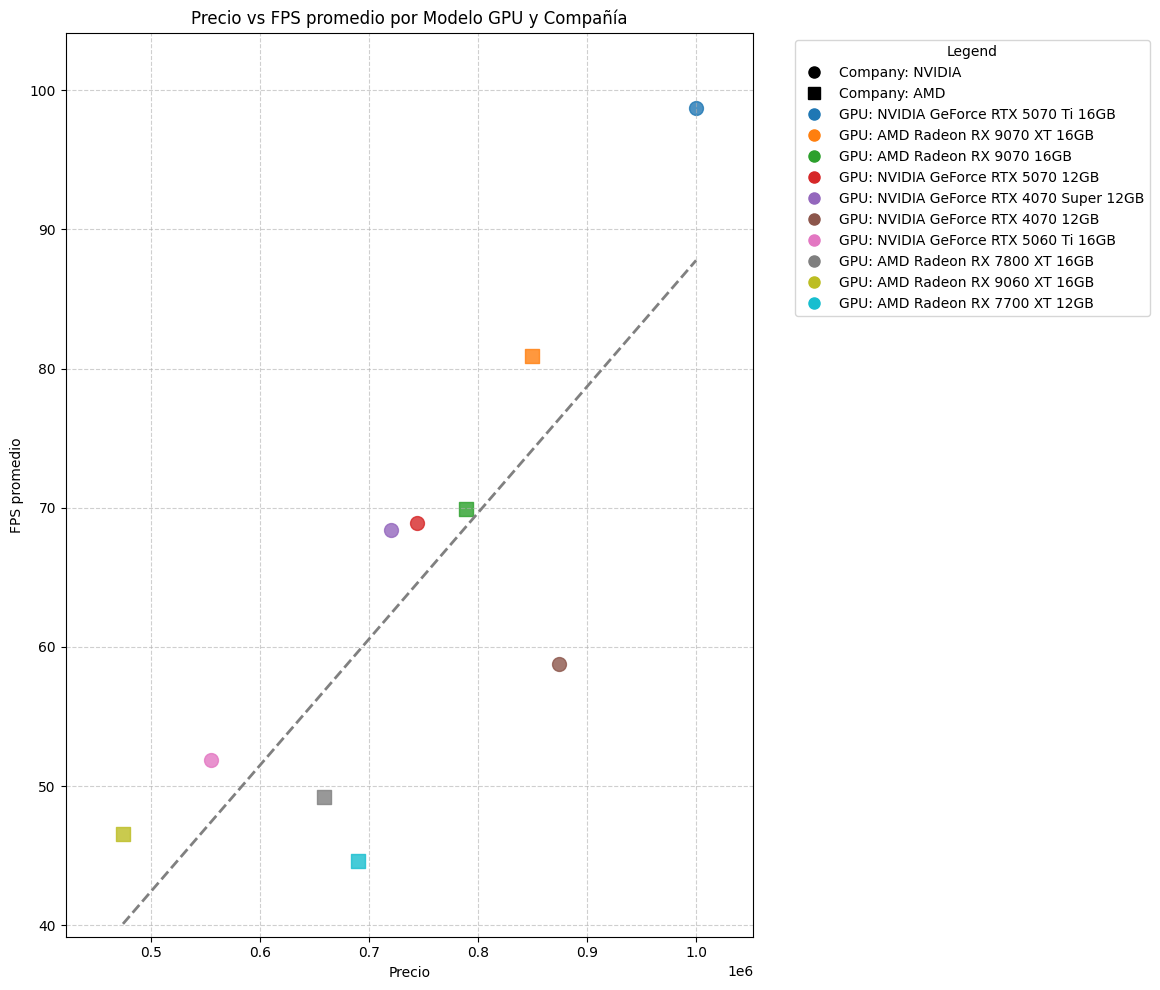

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Create graph 1: Scatterplot

# Define colors for each unique Graphics Card final for consistency in the scatterplot
unique_gpus = user_summary_cleaned['Graphics Card final'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_gpus)))
color_map = {gpu: colors[i] for i, gpu in enumerate(unique_gpus)}

# Define markers for each unique company
unique_companies = user_summary_cleaned['company_solotodo'].unique()
markers = ['o', 's', 'D', '^', 'v', '<', '>'] # Example markers, add more if needed
marker_map = {company: markers[i % len(markers)] for i, company in enumerate(unique_companies)}


# Create a new figure and axes with a large size
fig, ax = plt.subplots(figsize=(14, 10)) # Increased figure size for better visibility

# Create the scatter plot
# Iterate through unique companies and then unique GPUs within each company to plot with correct colors and markers
for company in unique_companies:
    company_df = user_summary_cleaned[user_summary_cleaned['company_solotodo'] == company]
    for gpu in company_df['Graphics Card final'].unique():
        gpu_df = company_df[company_df['Graphics Card final'] == gpu]
        ax.scatter(
            gpu_df['Precio_numeric'],
            gpu_df['FPS promedio_numeric'],
            label=f'{gpu} ({company})', # Label for legend
            color=color_map[gpu],
            marker=marker_map[company],
            s=100, # Increase point size
            alpha=0.8
        )

# Calculate and plot the trendline
# Ensure there are enough data points and variation for meaningful regression
if len(user_summary_cleaned) > 1 and user_summary_cleaned['Precio_numeric'].nunique() > 1:
    z = np.polyfit(user_summary_cleaned['Precio_numeric'], user_summary_cleaned['FPS promedio_numeric'], 1)
    p = np.poly1d(z)
    # Get min and max x values for the trendline
    x_min = user_summary_cleaned['Precio_numeric'].min()
    x_max = user_summary_cleaned['Precio_numeric'].max()
    ax.plot([x_min, x_max], [p(x_min), p(x_max)], color='grey', linestyle='--', linewidth=2, label='Trendline')
else:
    print("Not enough data points or variation in price to plot a trendline.")


# Set labels and title
ax.set_xlabel('Precio')
ax.set_ylabel('FPS promedio')
ax.set_title('Precio vs FPS promedio por Modelo GPU y Compañía')

# Set dynamic axis limits with padding
x_padding = (user_summary_cleaned['Precio_numeric'].max() - user_summary_cleaned['Precio_numeric'].min()) * 0.1
y_padding = (user_summary_cleaned['FPS promedio_numeric'].max() - user_summary_cleaned['FPS promedio_numeric'].min()) * 0.1

ax.set_xlim(user_summary_cleaned['Precio_numeric'].min() - x_padding, user_summary_cleaned['Precio_numeric'].max() + x_padding)
ax.set_ylim(user_summary_cleaned['FPS promedio_numeric'].min() - y_padding, user_summary_cleaned['FPS promedio_numeric'].max() + y_padding)


# Add grid
ax.grid(True, linestyle='--', alpha=0.6)

# Add legend with both GPU and Company information
# Create custom legend handles for markers (companies) and colors (GPUs)
legend_handles = []
for company in unique_companies:
    # Add a proxy artist for the marker style
    legend_handles.append(plt.Line2D([], [], color='black', marker=marker_map[company], linestyle='None',
                                    markersize=8, label=f'Company: {company}'))

for gpu in unique_gpus:
     # Add a proxy artist for the color
     legend_handles.append(plt.Line2D([], [], color=color_map[gpu], marker='o', linestyle='None',
                                      markersize=8, label=f'GPU: {gpu}'))


# Place the legend outside the plot
ax.legend(handles=legend_handles, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust rect to prevent legend overlap

# Show the plot
plt.show()

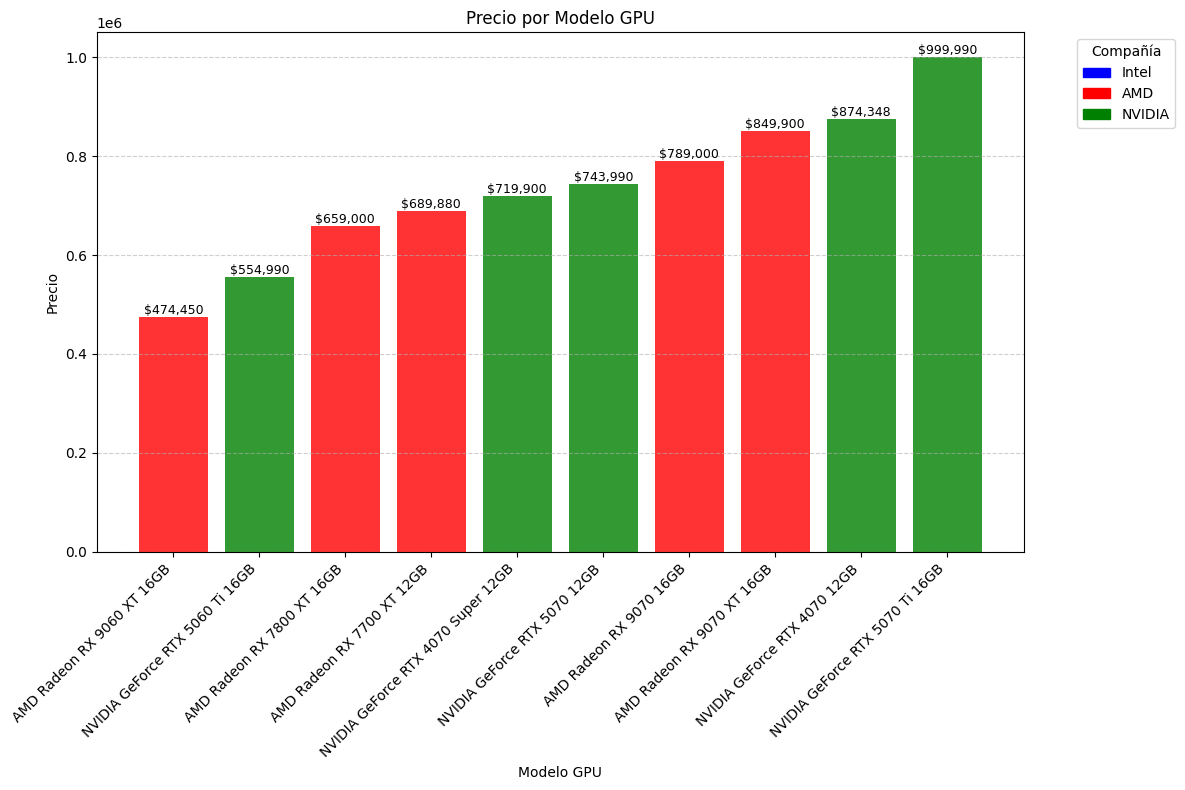

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches # Import patches module

# Create graph 2: bar plot for price

# Define the color mapping for companies
company_colors = {'Intel': 'blue', 'AMD': 'red', 'NVIDIA': 'green'}

# Sort the DataFrame by 'Precio_numeric' to get the order for the bars
user_summary_cleaned_sorted_price = user_summary_cleaned.sort_values(by='Precio_numeric').copy()

# Create a new figure and axes for the price bar chart
fig_precio, ax_precio = plt.subplots(figsize=(14, 8)) # Increased figure size

# Create the bar chart for 'Precio_numeric'
bars = ax_precio.bar(
    user_summary_cleaned_sorted_price['Graphics Card final'],
    user_summary_cleaned_sorted_price['Precio_numeric'],
    color=[company_colors[company] for company in user_summary_cleaned_sorted_price['company_solotodo']], # Color by company with specified colors
    alpha=0.8
)

# Add text labels for the price on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax_precio.text(bar.get_x() + bar.get_width()/2, yval, f'${yval:,.0f}', va='bottom', ha='center', fontsize=9) # Format as currency

# Set labels and title
ax_precio.set_xlabel('Modelo GPU')
ax_precio.set_ylabel('Precio')
ax_precio.set_title('Precio por Modelo GPU')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid
ax_precio.grid(axis='y', linestyle='--', alpha=0.6)

# Create a custom legend for companies using colored patches
legend_handles_company = [mpatches.Patch(color=color, label=company) for company, color in company_colors.items()] # Use mpatches.Patch

# Add the company legend
ax_precio.legend(handles=legend_handles_company, title='Compañía', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent labels overlapping
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust rect to prevent legend overlap

# Show the plot
plt.show()

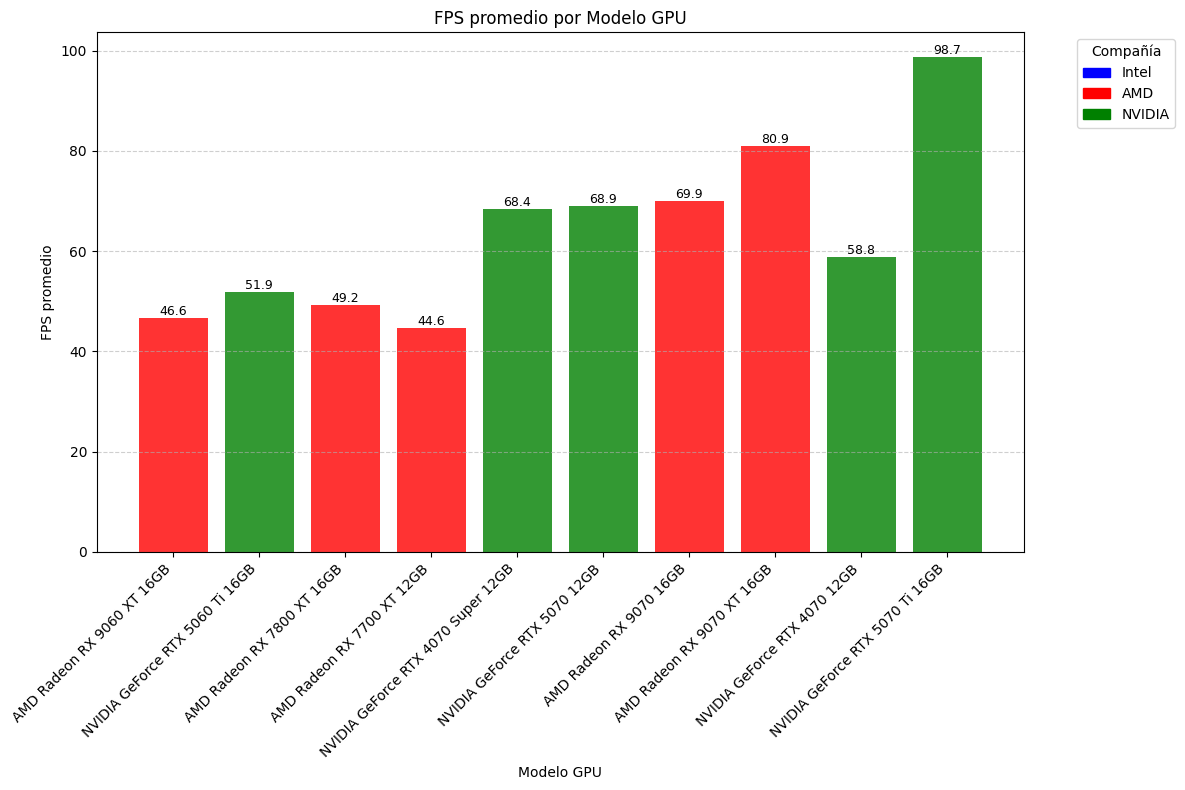

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches # Import patches module

# Create barplot for FPS

# Define the color mapping for companies (assuming company_colors is already defined)
# company_colors = {'Intel': 'blue', 'AMD': 'red', 'NVIDIA': 'green'}

# Get the order of GPUs from the sorted price DataFrame (assuming user_summary_cleaned_sorted_price is already defined)
gpu_order_by_price = user_summary_cleaned_sorted_price['Graphics Card final'].tolist()


# Create a new figure and axes for the FPS bar chart
fig_fps, ax_fps = plt.subplots(figsize=(14, 8)) # Increased figure size

# Create the bar chart for 'FPS promedio_numeric', using the same GPU order as the price chart
bars_fps = ax_fps.bar(
    user_summary_cleaned_sorted_price['Graphics Card final'],
    user_summary_cleaned_sorted_price['FPS promedio_numeric'],
    color=[company_colors[company] for company in user_summary_cleaned_sorted_price['company_solotodo']], # Color by company with specified colors
    alpha=0.8
)

# Add text labels for the FPS on top of the bars
for bar in bars_fps:
    yval = bar.get_height()
    ax_fps.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}', va='bottom', ha='center', fontsize=9) # Format FPS with one decimal

# Set labels and title
ax_fps.set_xlabel('Modelo GPU')
ax_fps.set_ylabel('FPS promedio')
ax_fps.set_title('FPS promedio por Modelo GPU')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid
ax_fps.grid(axis='y', linestyle='--', alpha=0.6)

# Create a custom legend for companies using colored patches (assuming company_colors is defined)
legend_handles_company = [mpatches.Patch(color=color, label=company) for company, color in company_colors.items()]

# Add the company legend
ax_fps.legend(handles=legend_handles_company, title='Compañía', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent labels overlapping
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust rect to prevent legend overlap

# Show the plot
plt.show()

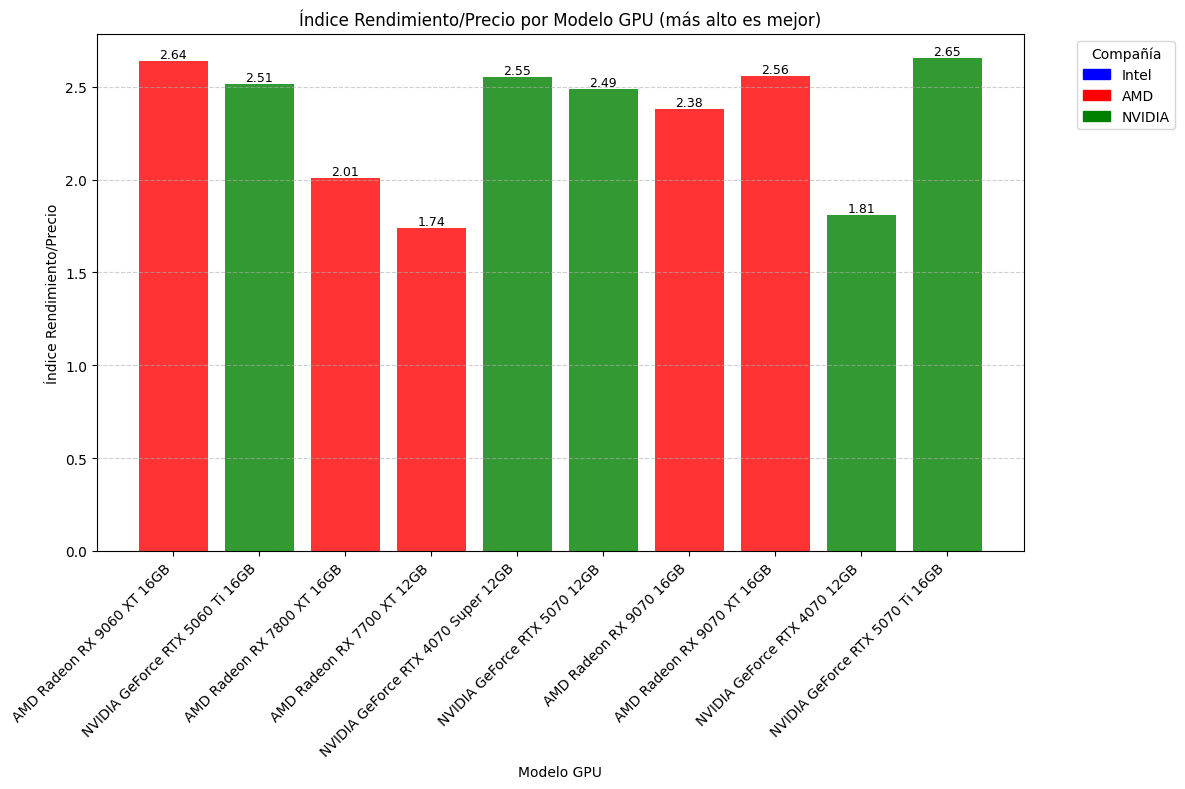

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches # Import patches module

# Create barplot for Rendimiento/Precio

# Define the color mapping for companies (assuming company_colors is already defined)
# company_colors = {'Intel': 'blue', 'AMD': 'red', 'NVIDIA': 'green'}

# Get the order of GPUs from the sorted price DataFrame (assuming user_summary_cleaned_sorted_price is already defined)
gpu_order_by_price = user_summary_cleaned_sorted_price['Graphics Card final'].tolist()

# Create a new figure and axes for the performance-per-price bar chart
fig_rendimiento, ax_rendimiento = plt.subplots(figsize=(14, 8)) # Increased figure size

# Create the bar chart for 'Índice Rendimiento/Precio_numeric', using the same GPU order
bars_rendimiento = ax_rendimiento.bar(
    user_summary_cleaned_sorted_price['Graphics Card final'],
    user_summary_cleaned_sorted_price['Índice Rendimiento/Precio_numeric'],
    color=[company_colors[company] for company in user_summary_cleaned_sorted_price['company_solotodo']], # Color by company with specified colors
    alpha=0.8
)

# Add text labels for the index on top of the bars
for bar in bars_rendimiento:
    yval = bar.get_height()
    ax_rendimiento.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', va='bottom', ha='center', fontsize=9) # Format index with two decimals

# Set labels and title
ax_rendimiento.set_xlabel('Modelo GPU')
ax_rendimiento.set_ylabel('Índice Rendimiento/Precio')
ax_rendimiento.set_title('Índice Rendimiento/Precio por Modelo GPU (más alto es mejor)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid
ax_rendimiento.grid(axis='y', linestyle='--', alpha=0.6)

# Add the company legend using colored patches (assuming company_colors is defined)
legend_handles_company = [mpatches.Patch(color=color, label=company) for company, color in company_colors.items()]

# Add the company legend
ax_rendimiento.legend(handles=legend_handles_company, title='Compañía', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent labels overlapping
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust rect to prevent legend overlap

# Show the plot
plt.show()

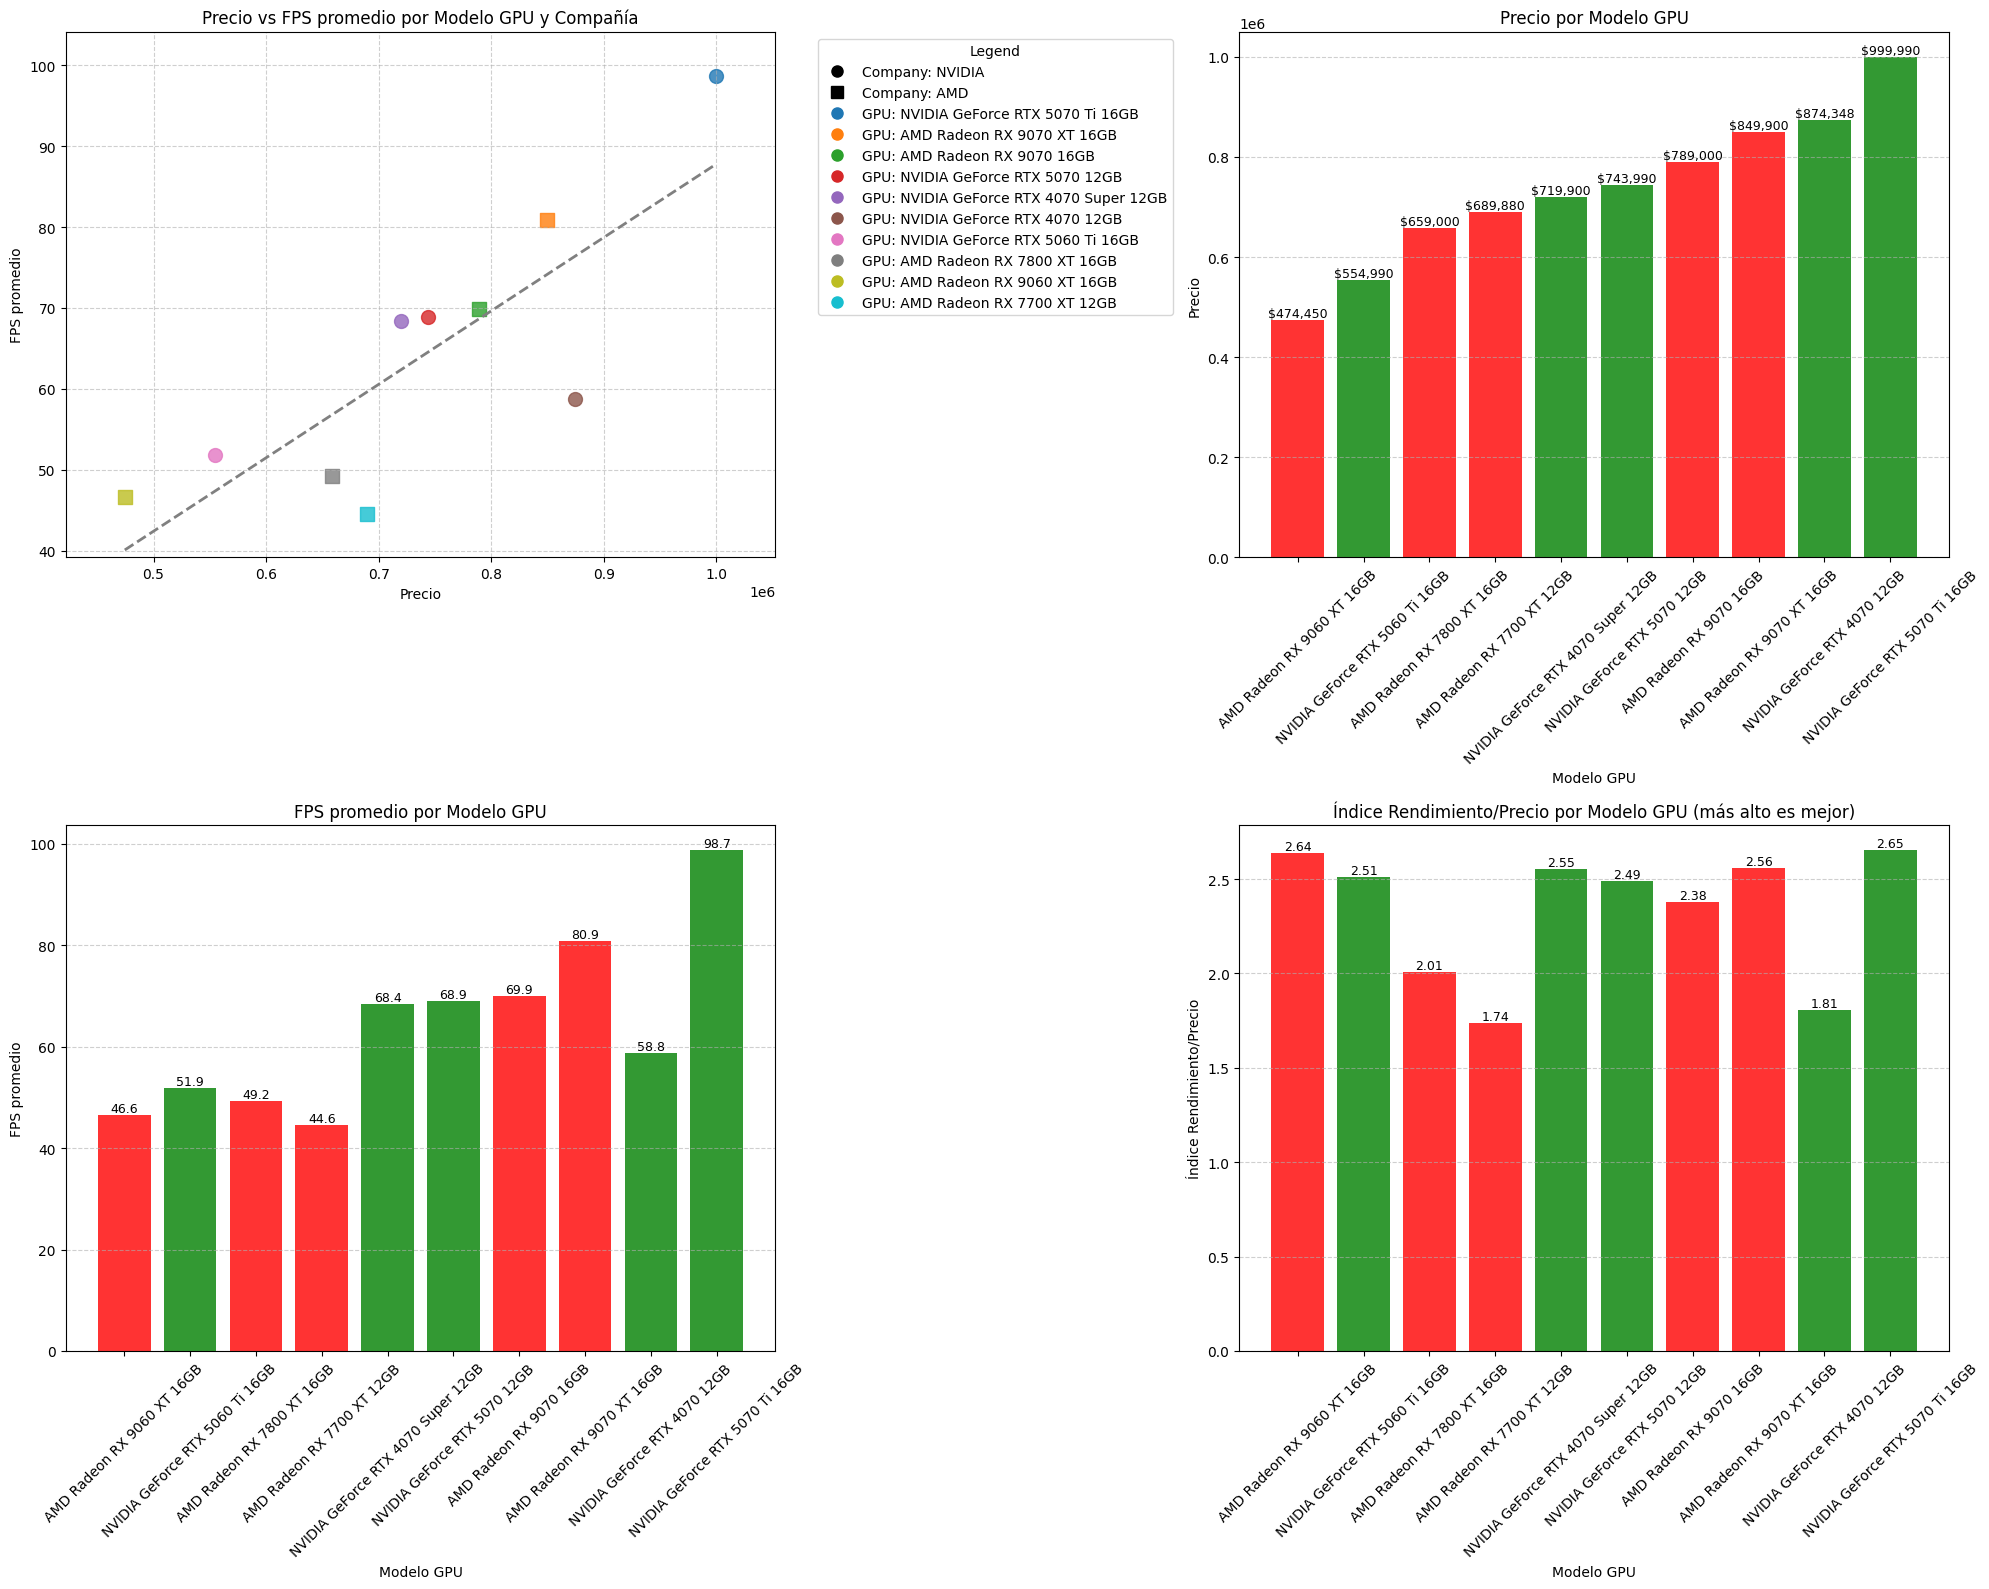

In [40]:
# Combine the four plots into a 2x2 grid
# Create a new figure to hold the subplots
fig_grid, axes = plt.subplots(2, 2, figsize=(20, 16)) # Increased overall grid size

# Transfer the content of each individual plot to the grid subplots

# Scatterplot (Top-Left)
ax_scatter = axes[0, 0]
# Re-plot scatter points
for company in unique_companies:
    company_df = user_summary_cleaned[user_summary_cleaned['company_solotodo'] == company]
    for gpu in company_df['Graphics Card final'].unique():
        gpu_df = company_df[company_df['Graphics Card final'] == gpu]
        ax_scatter.scatter(
            gpu_df['Precio_numeric'],
            gpu_df['FPS promedio_numeric'],
            label=f'{gpu} ({company})', # Label for legend
            color=[color_map[gpu] for _ in gpu_df.index], # Ensure color list matches number of points
            marker=marker_map[company],
            s=100, # Increase point size
            alpha=0.8
        )

# Re-plot trendline
if len(user_summary_cleaned) > 1 and user_summary_cleaned['Precio_numeric'].nunique() > 1:
    z = np.polyfit(user_summary_cleaned['Precio_numeric'], user_summary_cleaned['FPS promedio_numeric'], 1)
    p = np.poly1d(z)
    x_min = user_summary_cleaned['Precio_numeric'].min()
    x_max = user_summary_cleaned['Precio_numeric'].max()
    ax_scatter.plot([x_min, x_max], [p(x_min), p(x_max)], color='grey', linestyle='--', linewidth=2, label='Trendline')

# Set scatterplot labels, title, limits, and grid
ax_scatter.set_xlabel('Precio')
ax_scatter.set_ylabel('FPS promedio')
ax_scatter.set_title('Precio vs FPS promedio por Modelo GPU y Compañía')

# Set dynamic axis limits with padding
x_padding = (user_summary_cleaned['Precio_numeric'].max() - user_summary_cleaned['Precio_numeric'].min()) * 0.1
y_padding = (user_summary_cleaned['FPS promedio_numeric'].max() - user_summary_cleaned['FPS promedio_numeric'].min()) * 0.1
ax_scatter.set_xlim(user_summary_cleaned['Precio_numeric'].min() - x_padding, user_summary_cleaned['Precio_numeric'].max() + x_padding)
ax_scatter.set_ylim(user_summary_cleaned['FPS promedio_numeric'].min() - y_padding, user_summary_cleaned['FPS promedio_numeric'].max() + y_padding)

ax_scatter.grid(True, linestyle='--', alpha=0.6)

# Create legend for the scatterplot
legend_handles_scatter = []
for company in unique_companies:
    legend_handles_scatter.append(plt.Line2D([], [], color='black', marker=marker_map[company], linestyle='None',
                                    markersize=8, label=f'Company: {company}'))
# Add GPU color legend
for gpu in unique_gpus:
     legend_handles_scatter.append(plt.Line2D([], [], color=color_map[gpu], marker='o', linestyle='None',
                                      markersize=8, label=f'GPU: {gpu}'))
ax_scatter.legend(handles=legend_handles_scatter, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')


# Price Bar Chart (Top-Right)
ax_precio = axes[0, 1]
bars_precio = ax_precio.bar(
    user_summary_cleaned_sorted_price['Graphics Card final'],
    user_summary_cleaned_sorted_price['Precio_numeric'],
    color=[company_colors[company] for company in user_summary_cleaned_sorted_price['company_solotodo']],
    alpha=0.8
)
for bar in bars_precio:
    yval = bar.get_height()
    ax_precio.text(bar.get_x() + bar.get_width()/2, yval, f'${yval:,.0f}', va='bottom', ha='center', fontsize=9)
ax_precio.set_xlabel('Modelo GPU')
ax_precio.set_ylabel('Precio')
ax_precio.set_title('Precio por Modelo GPU')
ax_precio.tick_params(axis='x', rotation=45)
ax_precio.grid(axis='y', linestyle='--', alpha=0.6)

# FPS Bar Chart (Bottom-Left)
ax_fps = axes[1, 0]
bars_fps = ax_fps.bar(
    user_summary_cleaned_sorted_price['Graphics Card final'],
    user_summary_cleaned_sorted_price['FPS promedio_numeric'],
    color=[company_colors[company] for company in user_summary_cleaned_sorted_price['company_solotodo']],
    alpha=0.8
)
for bar in bars_fps:
    yval = bar.get_height()
    ax_fps.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}', va='bottom', ha='center', fontsize=9)
ax_fps.set_xlabel('Modelo GPU')
ax_fps.set_ylabel('FPS promedio')
ax_fps.set_title('FPS promedio por Modelo GPU')
ax_fps.tick_params(axis='x', rotation=45)
ax_fps.grid(axis='y', linestyle='--', alpha=0.6)

# Rendimiento/Precio Bar Chart (Bottom-Right)
ax_rendimiento = axes[1, 1]
bars_rendimiento = ax_rendimiento.bar(
    user_summary_cleaned_sorted_price['Graphics Card final'],
    user_summary_cleaned_sorted_price['Índice Rendimiento/Precio_numeric'],
    color=[company_colors[company] for company in user_summary_cleaned_sorted_price['company_solotodo']],
    alpha=0.8
)
for bar in bars_rendimiento:
    yval = bar.get_height()
    ax_rendimiento.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', va='bottom', ha='center', fontsize=9)
ax_rendimiento.set_xlabel('Modelo GPU')
ax_rendimiento.set_ylabel('Índice Rendimiento/Precio')
ax_rendimiento.set_title('Índice Rendimiento/Precio por Modelo GPU (más alto es mejor)')
ax_rendimiento.tick_params(axis='x', rotation=45)
ax_rendimiento.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

# Show the combined grid plot
plt.show()